In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns

sns.set_theme(context='talk', 
              style='whitegrid', 
              palette='Set2',
              font_scale=1.4, 
              rc={'figure.figsize': (14, 6)})

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import plotly
pio.templates.default = 'plotly_white+presentation'



import scipy.constants as sc

hbarc = sc.hbar*sc.speed_of_light/sc.giga/sc.electron_volt / sc.femto

import json
import os
import sys
sys.path.append('../src')

from luscher_lib import Luscher_zeta, Kcot_luscher

from tqdm import tqdm

# load data

In [3]:
df_conf = pd.read_csv('../data/CLS_conf_inf.csv')
df_conf['a2 [fm2]'] = df_conf['a [fm]'].apply(lambda x: x**2)
df_conf['a_inv [GeV]'] = (hbarc / df_conf['a [fm]']).round(3) # add lattice unit
df_conf

,Label,N_f,beta,kappa,size_L,size_T,bdy.cond.,a [fm],m_pi [MeV],L [fm],m_pi L,m_B [GeV],N_conf,N_tsrc,N_meas,N_LapH,a2 [fm2],a_inv [GeV]
0,N300,3,3.70,0.137000,48,128,open,0.0498,422,2.4,5.1,1.19,2047,12,24564,32,0.002480,3.962
1,N202,3,3.55,0.137000,48,128,open,0.0642,412,3.1,6.4,1.17,899,8,10788,68,0.004122,3.074
2,H200,3,3.55,0.137000,32,96,open,0.0642,419,2.1,4.4,1.19,2000,8,16000,20,0.004122,3.074
3,B450,3,3.46,0.136890,32,64,periodic,0.0762,417,2.4,5.2,1.18,1612,8,25762,32,0.005806,2.590
4,H101,3,3.40,0.136760,32,96,open,0.0865,417,2.8,5.9,1.16,2016,4,12096,48,0.007482,2.281
5,U103,3,3.40,0.136760,24,128,open,0.0865,414,2.1,4.4,1.18,5658,5,45264,20,0.007482,2.281
6,A653,3,3.34,0.136572,24,48,periodic,0.0992,424,2.4,5.1,1.16,5050,4,40400,32,0.009841,1.989
7,E5,2,5.30,0.136250,32,64,periodic,0.0658,436,2.1,4.7,1.29,2000,4,16000,30,0.004330,2.999
8,E1,2,5.30,0.135500,32,64,periodic,0.0658,978,2.1,10.4,2.03,168,8,2688,30,0.004330,2.999


In [4]:
# for utility
lat_unit_dic = df_conf.set_index('Label')['a [fm]'].to_dict()
a_inv_dic = df_conf.set_index('Label')['a_inv [GeV]'].to_dict()
L_fm_dic = df_conf.set_index('Label')['L [fm]'].to_dict()
L_dic = df_conf.set_index('Label')['size_L'].to_dict()
pion_mass_dic = df_conf.set_index('Label')['m_pi [MeV]'].to_dict()
baryon_mass_dic = df_conf.set_index('Label')['m_B [GeV]'].to_dict()
label_list = list(df_conf['Label'])

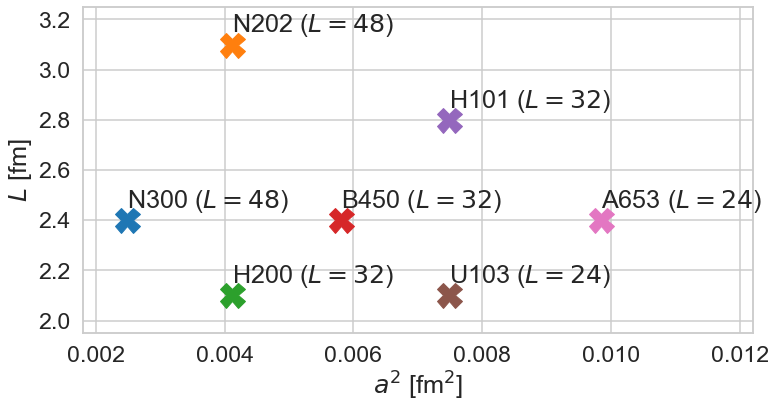

In [5]:
with sns.color_palette('tab10'):
    fig, ax = plt.subplots(figsize=(12, 6))
    for label in label_list:
        if label in ['E5', 'E1']: continue
        a2 = lat_unit_dic.get(label)**2
        L_fm = L_fm_dic.get(label)
        ax.plot(a2, L_fm, 'X', ms=25)
        ax.text(a2, L_fm+0.05, fr'{label} ($L = {L_dic.get(label)}$)')
    ax.set(xlabel=r'$a^2$ [fm$^2$]', ylabel='$L$ [fm]', xlim=(0.0018, 0.0122), ylim=(1.95, 3.25))
#    fig.savefig('../figs/SU3_ensembles.png', bbox_inches='tight')

In [6]:
df_p2 = pd.read_csv('../data/p_square_spin_zero.csv')
df_p2

,label,frame,level,p^2 [GeV^2],p^2 (95CI lower)[GeV^2],p^2 (95CI upper)[GeV^2]
0,N300,P000,0,-0.052776,-0.058083,-0.047491
1,N300,P000,1,0.220941,0.215210,0.226353
2,N300,P000,2,0.530439,0.523077,0.537480
3,N300,P001,0,-0.004604,-0.010711,0.000879
4,N300,P001,1,0.289442,0.281795,0.297300
...,...,...,...,...,...,...
85,E1,P011,0,-0.013906,-0.028521,0.001363
86,E1,P011,1,0.155614,0.145779,0.164732
87,E1,P111,0,0.021042,-0.007314,0.052523
88,E1,P111,1,0.208173,0.193195,0.223386


In [7]:
class LD(object):
    def __init__(self, label, frame, level, p2GeV2, p2GeV2_min, p2GeV2_max):
        self.label = label
        self.frame = frame
        self.level = level
        self.d = [int(frame[1]), int(frame[2]), int(frame[3])]
        self.L = L_dic.get(label)
        self.lat_unit = lat_unit_dic.get(label)
        self.a_inv = a_inv_dic.get(label)
        self.m_B = baryon_mass_dic.get(label)/self.a_inv
        self.m_pi = pion_mass_dic.get(label)/self.a_inv * 1e-3
        
        self.kcs = Kcot_luscher(self.L, self.m_B, self.m_B, d=self.d)
        
        self.k2 = p2GeV2 / self.a_inv**2
        self.k2_max = p2GeV2_max / self.a_inv**2
        self.k2_min = p2GeV2_min / self.a_inv**2
        
        # error bar
        self.k2mpi2s = np.linspace(self.k2_min/self.m_pi**2, self.k2_max/self.m_pi**2)
        self.kcot_mpis = np.array([self.kcs.kcot(k2 * self.m_pi**2)/self.m_pi for k2 in self.k2mpi2s])
        # central value
        self.k2mpi2 = self.k2 / self.m_pi**2
        self.kcot_mpi = self.kcs.kcot(self.k2) / self.m_pi
        
    def generate_reference_line(self, xlim, ylim, dk2=0.01, point_max=1000, delta_y_limit=0.5):
        self.xlim = xlim
        self.ylim = ylim
        def _gen_reference_line(x0, y0, dk2):
            _k2mpi2_ref = [x0]
            _kcot_mpi_ref = [y0]
            for i in range(point_max):
                x1 = x0 + dk2
                y1 = self.kcs.kcot(x1 * self.m_pi**2)/self.m_pi
                
                if np.abs(y1 - y0) > delta_y_limit:
                    dk2 /= 2
                    continue
                    
                _k2mpi2_ref.append(x1)
                _kcot_mpi_ref.append(y1)
                                
                if (y1 >= ylim[1]) or (y1 <= ylim[0]):
                    break
                if (x1 >= xlim[1]) or (x1 <= xlim[0]):
                    break

                x0, y0 = x1, y1
            return _k2mpi2_ref, _kcot_mpi_ref

        _k2mpi2_ref_1, _kcot_mpi_ref_1 = _gen_reference_line(self.k2mpi2, self.kcot_mpi, dk2)
        _k2mpi2_ref_2, _kcot_mpi_ref_2 = _gen_reference_line(self.k2mpi2, self.kcot_mpi, - dk2)
        
        self.k2mpi2_ref = np.concatenate([_k2mpi2_ref_2[1:][::-1], _k2mpi2_ref_1])
        self.kcot_mpi_ref = np.concatenate([_kcot_mpi_ref_2[1:][::-1], _kcot_mpi_ref_1])
        
    def dump_json(self, out_dir='../data/pcot_p2'):
        data = {
            'label' : self.label,
            'frame' : self.frame,
            'level': self.level,
            'L' : self.L,
            'lat_unit': self.lat_unit,
            'a_inv': self.a_inv,
            'm_B': self.m_B,
            'm_pi': self.m_pi,
            'k2mpi2': self.k2mpi2,
            'kcot_mpi': self.kcot_mpi,
            'k2mpi2s': list(self.k2mpi2s),
            'kcot_mpis': list(self.kcot_mpis),
            'k2mpi2_ref': list(self.k2mpi2_ref),
            'kcot_mpi_ref': list(self.kcot_mpi_ref),
            'xlim': list(self.xlim),
            'ylim': list(self.ylim)
        }
        with open(os.path.join(out_dir, f'{self.label}_{self.frame}_{self.level}_spin_zero.json'), 'w') as f:
            json.dump(data, f, indent=4)
        

In [8]:
def calc_kcot_vs_k2(label, frame, level, xlim, ylim, plot_fig=True):
    label, frame, level, p2GeV2, p2GeV2_min, p2GeV2_max = df_p2.query('label == @label & frame == @frame & level == @level').values[0]
    ld = LD(label, frame, level, p2GeV2, p2GeV2_min, p2GeV2_max)
    ld.generate_reference_line(xlim, ylim)
    
    ld.dump_json() # save

    if plot_fig:
        fig, ax = plt.subplots()

        c = 'C1'
        ax.plot(ld.k2mpi2s, ld.kcot_mpis, color=c, zorder=3, lw=5, label=f'{label} ({frame}) {level}')
        ax.plot(ld.k2mpi2, ld.kcot_mpi, 'o', ms=25, color=c, zorder=3)
        ax.plot(ld.k2mpi2_ref, ld.kcot_mpi_ref, '--',color='grey')


        if xlim[0] < 0:
            xbs = np.concatenate([np.linspace(xlim[0], -1e-1), np.linspace(-1e-1, -1e-5)])
            ax.plot(xbs, - np.sqrt(-xbs), color='black', ls='-')

        ax.legend()
        ax.axhline(0, color='black')
        ax.axvline(0, color='black')
        ax.set(xlabel=r'$(p/m_\pi)^2$', ylabel=r'$p\cot\delta/m_\pi$', xlim=xlim, ylim=ylim)
    return ld


# calculate phase shift

You can skip the following calculation by loading "../data/pickle/pcot_vs_p2.pickle".

In [9]:
label_list

['N300', 'N202', 'H200', 'B450', 'H101', 'U103', 'A653', 'E5', 'E1']

100%|██████████| 5/5 [01:27<00:00, 17.55s/it]

CPU times: user 1min 24s, sys: 1.58 s, total: 1min 25s
Wall time: 1min 27s


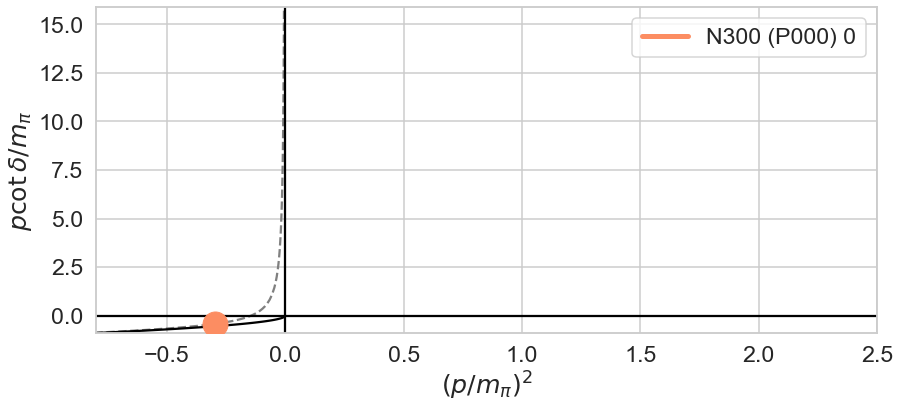

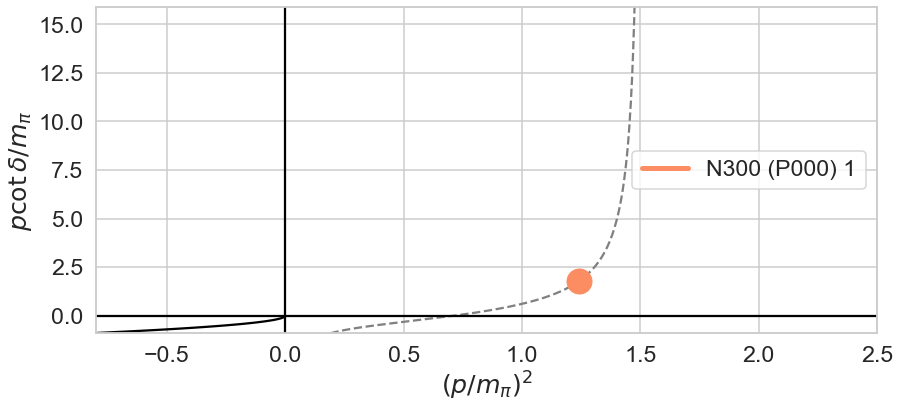

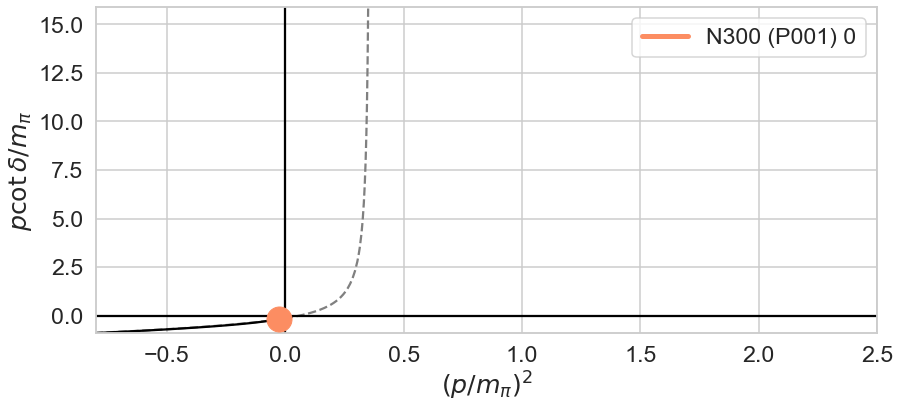

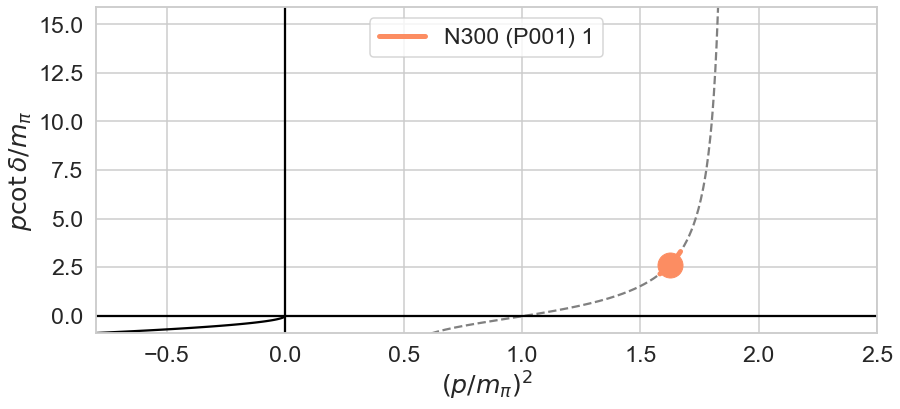

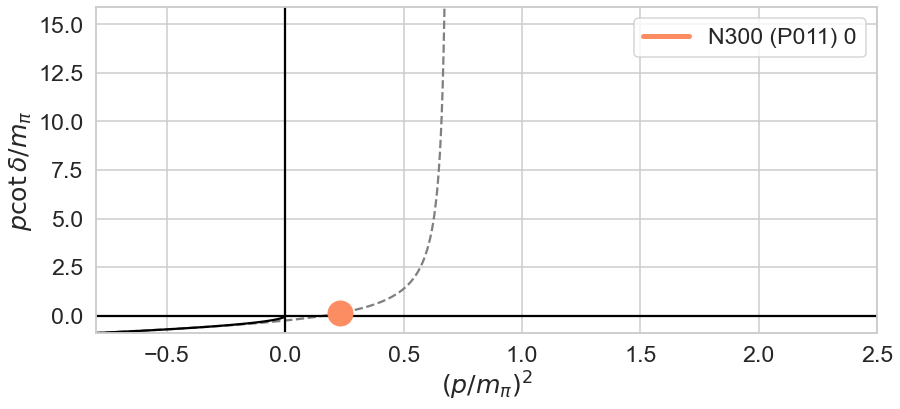

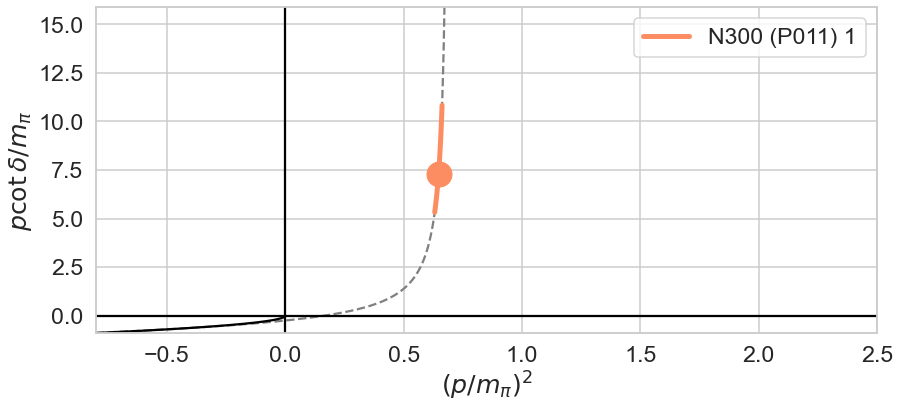

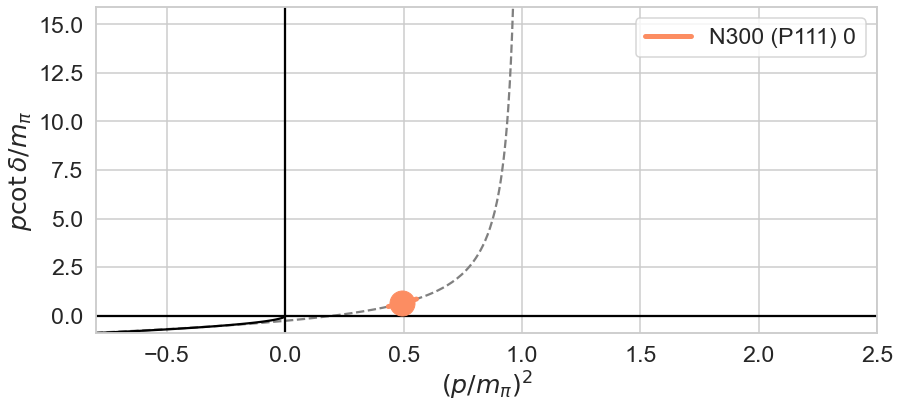

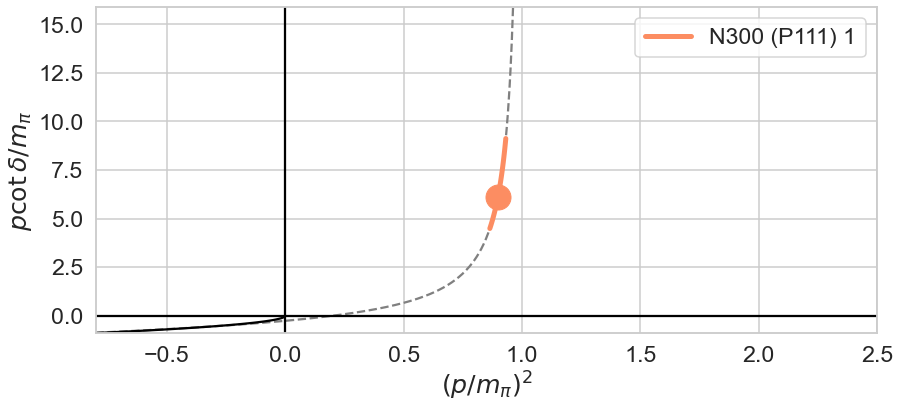

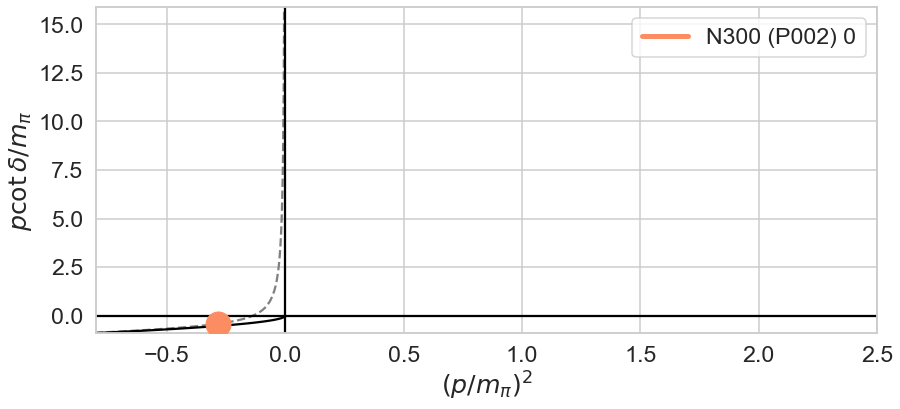

In [10]:
%%time
label = 'N300'
for frame in tqdm(['P000', 'P001', 'P011', 'P111', 'P002']):
    for level in [0, 1]:
        if (frame == 'P002') and (level == 1):
            continue
        _ = calc_kcot_vs_k2(label, frame, level, xlim=(-0.8, 2.5), ylim=(-0.9, 15.9))

100%|██████████| 5/5 [01:31<00:00, 18.31s/it]


CPU times: user 1min 25s, sys: 1.6 s, total: 1min 27s
Wall time: 1min 31s


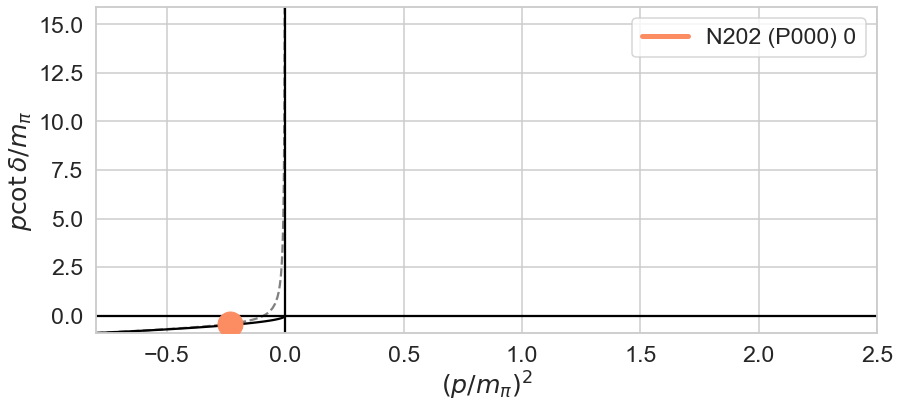

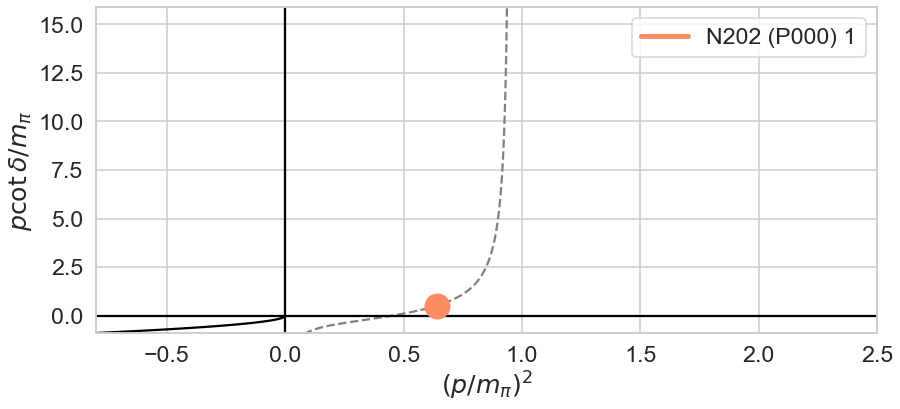

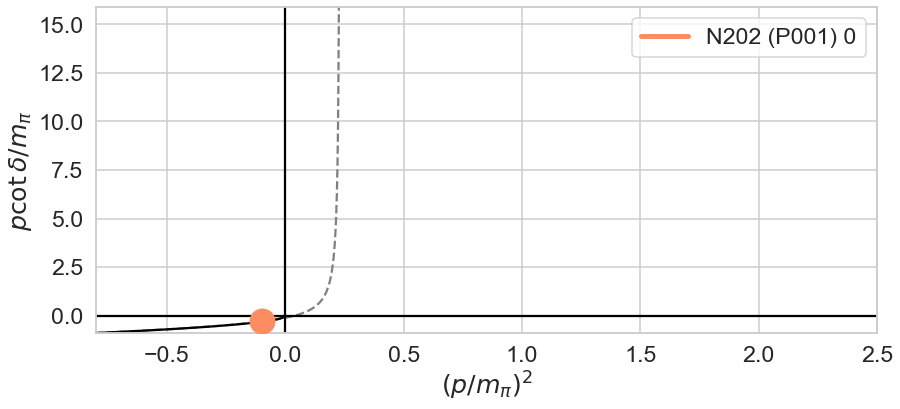

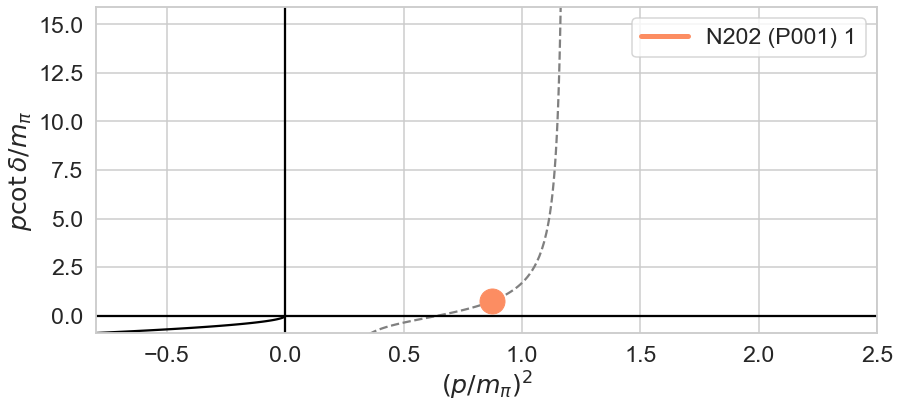

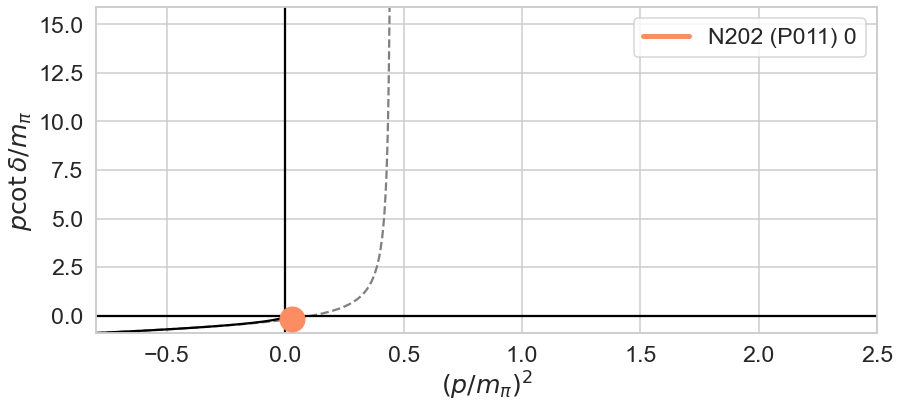

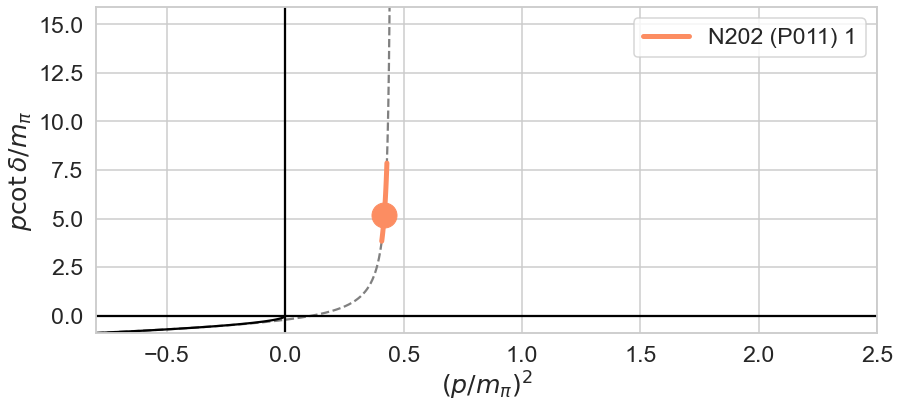

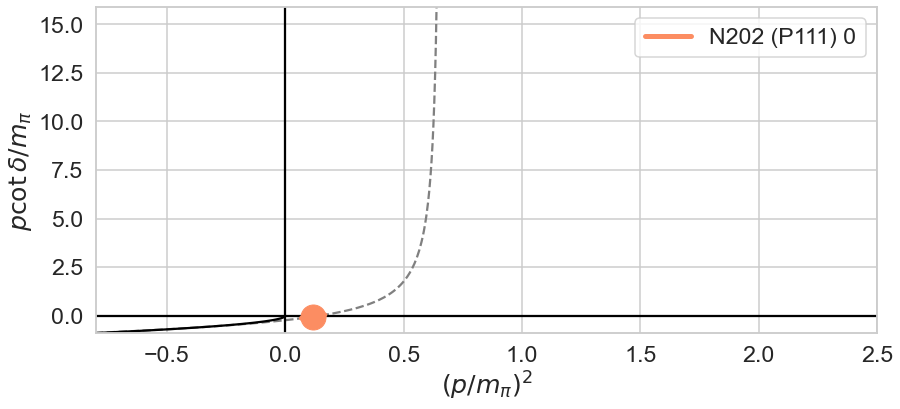

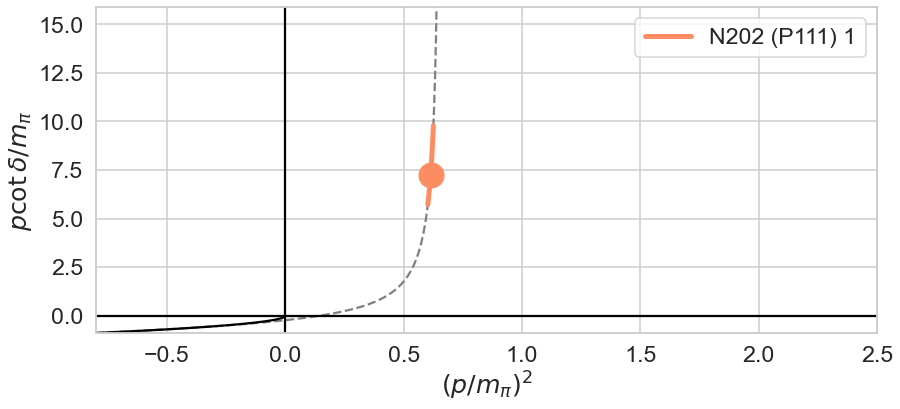

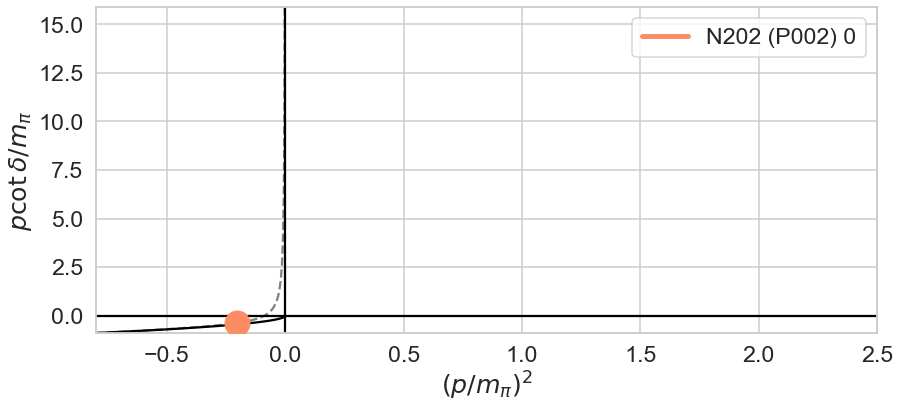

In [11]:
%%time
label = 'N202'
for frame in tqdm(['P000', 'P001', 'P011', 'P111', 'P002']):
    for level in [0, 1]:
        if (frame == 'P002') and (level == 1):
            continue
        _ = calc_kcot_vs_k2(label, frame, level, xlim=(-0.8, 2.5), ylim=(-0.9, 15.9))

100%|██████████| 5/5 [01:11<00:00, 14.37s/it]

CPU times: user 1min 8s, sys: 1.33 s, total: 1min 10s
Wall time: 1min 11s


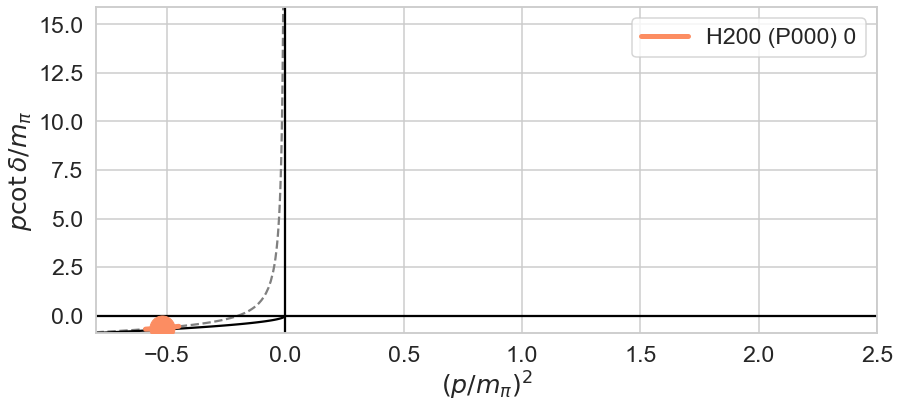

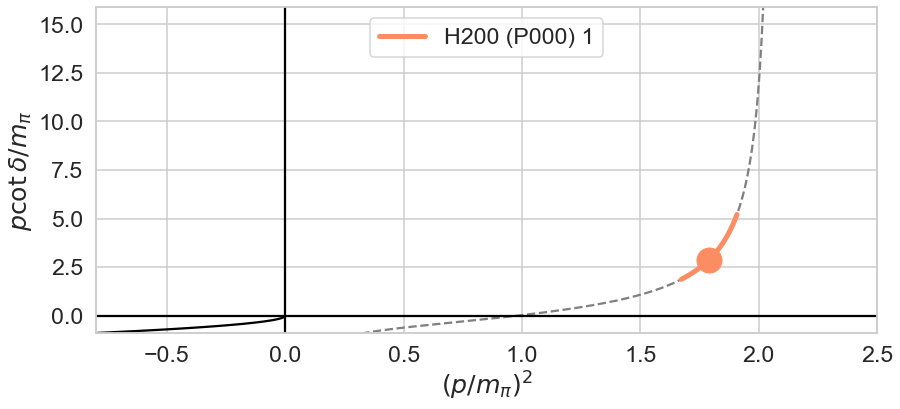

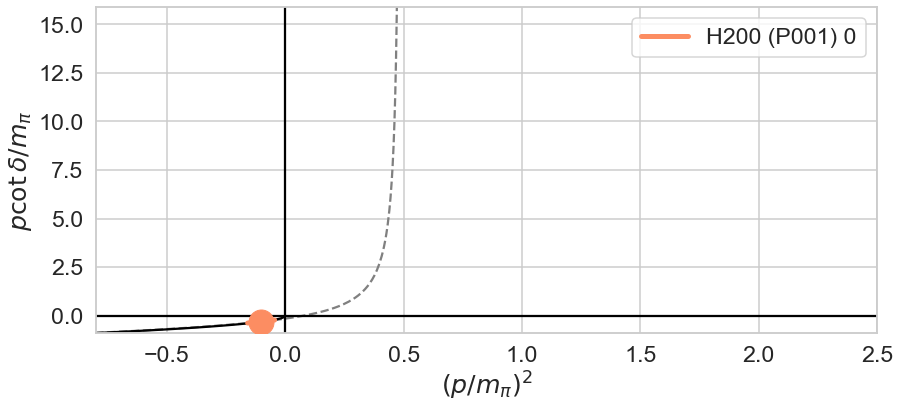

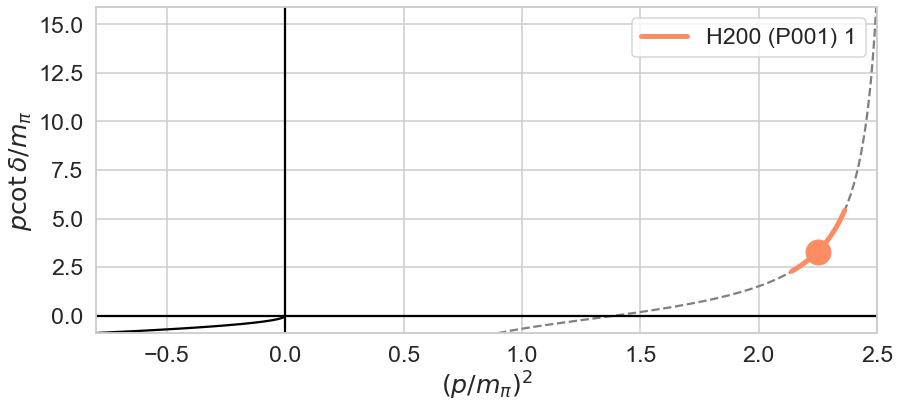

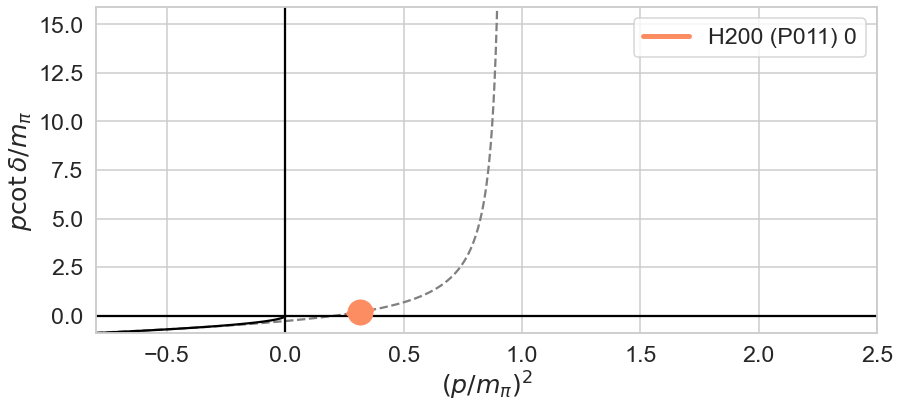

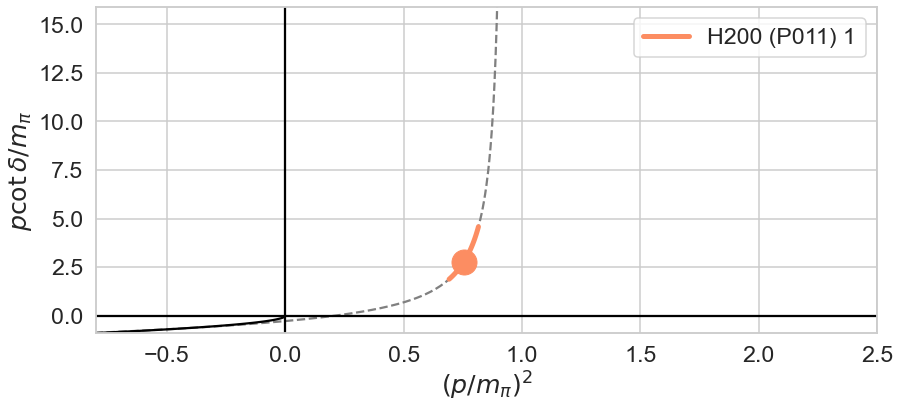

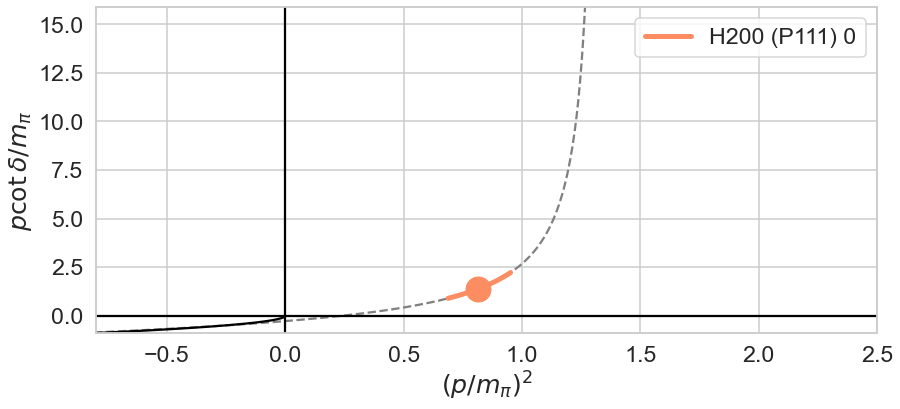

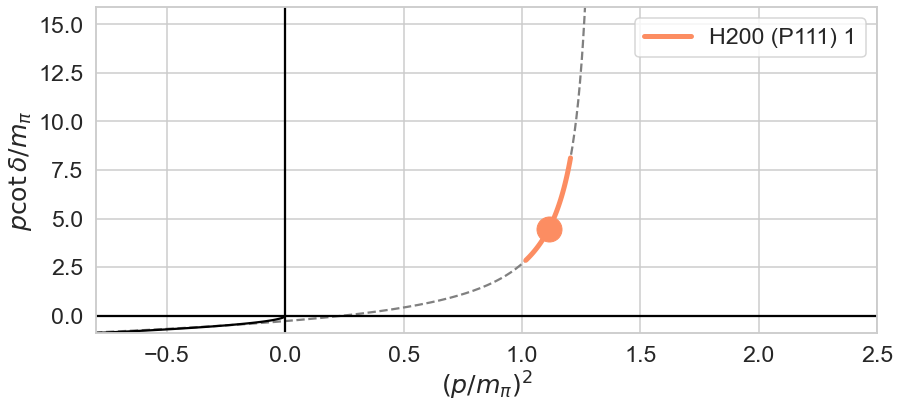

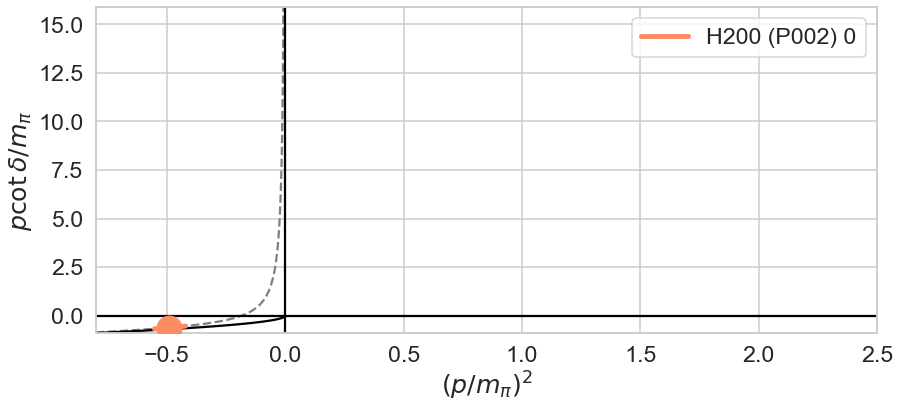

In [12]:
%%time
label = 'H200'
for frame in tqdm(['P000', 'P001', 'P011', 'P111', 'P002']):
    for level in [0, 1]:
        if (frame == 'P002') and (level == 1):
            continue
        _ = calc_kcot_vs_k2(label, frame, level, xlim=(-0.8, 2.5), ylim=(-0.9, 15.9))

100%|██████████| 5/5 [01:33<00:00, 18.61s/it]


CPU times: user 1min 16s, sys: 1.84 s, total: 1min 18s
Wall time: 1min 33s


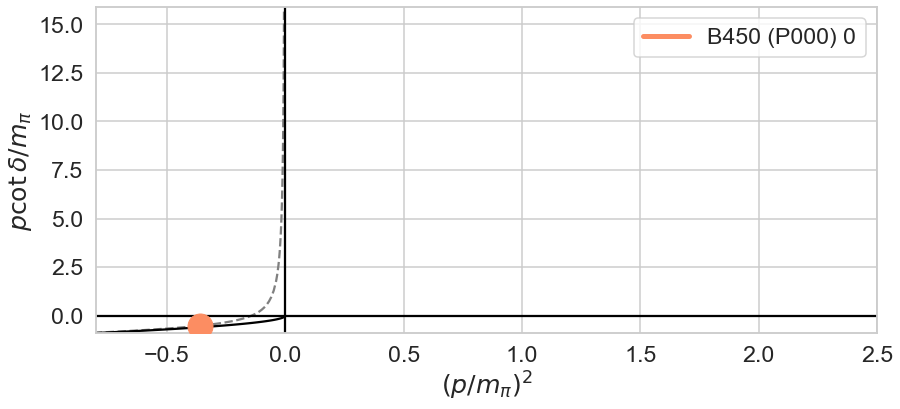

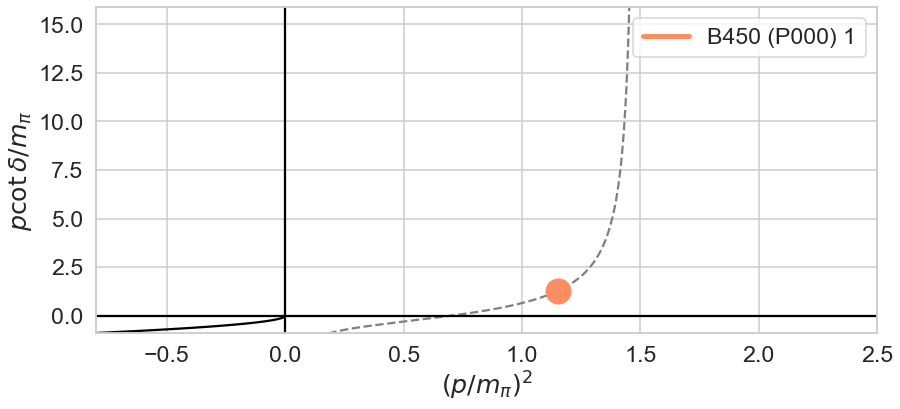

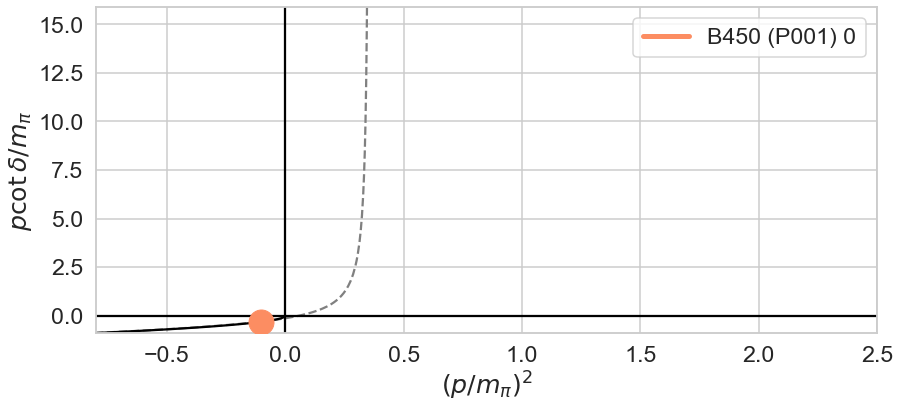

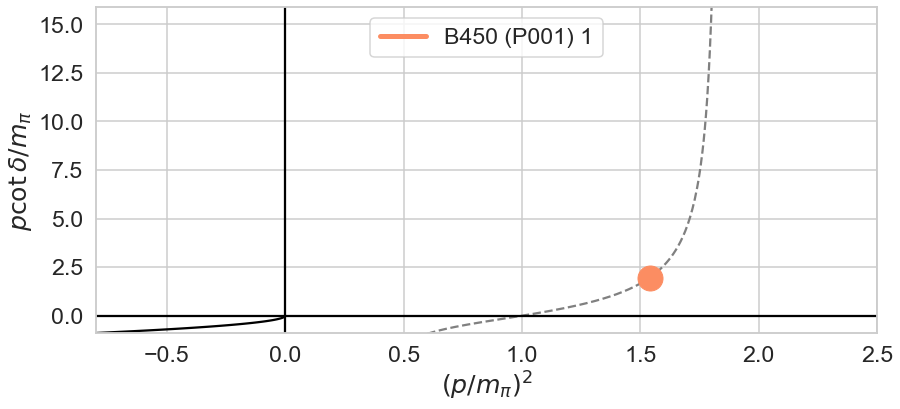

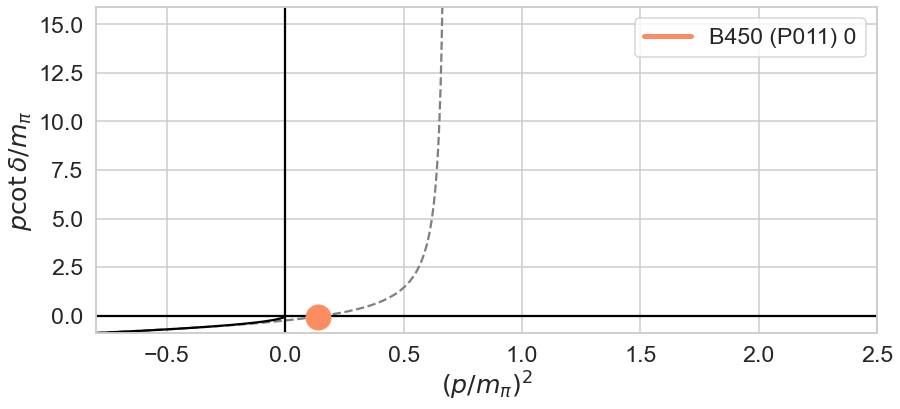

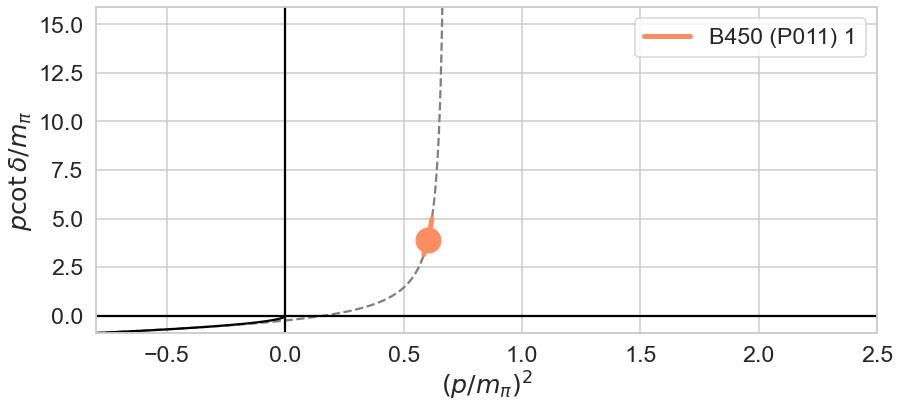

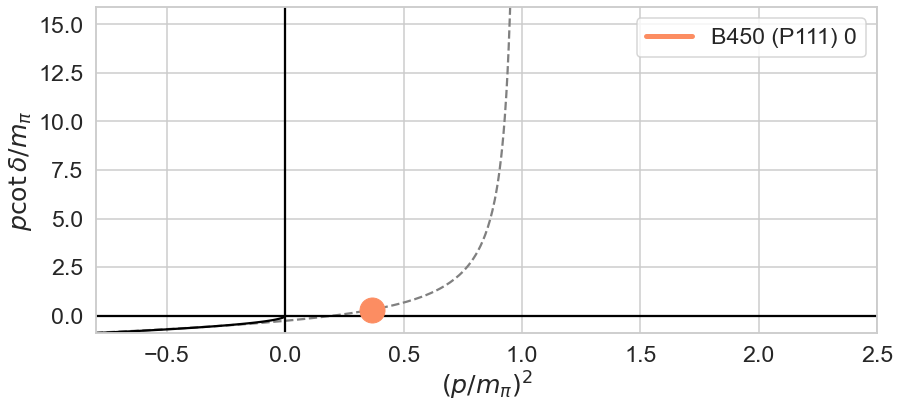

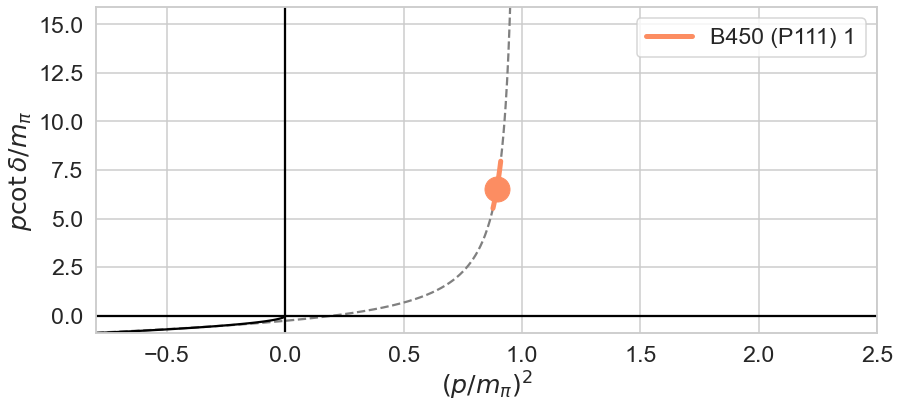

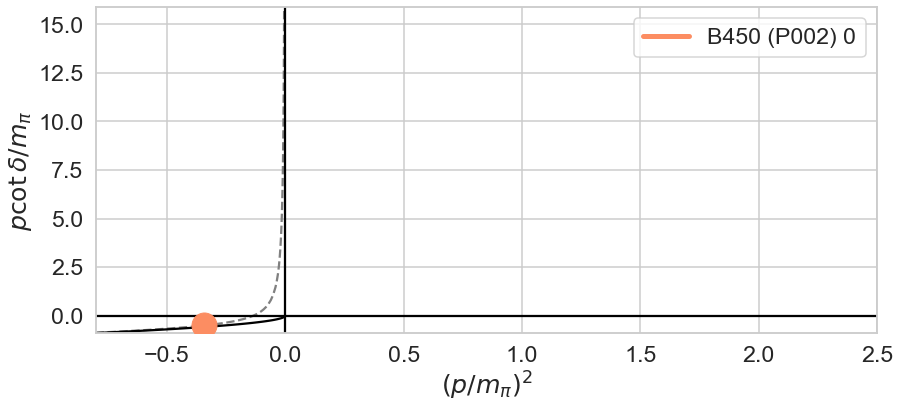

In [13]:
%%time
label = 'B450'
for frame in tqdm(['P000', 'P001', 'P011', 'P111', 'P002']):
    for level in [0, 1]:
        if (frame == 'P002') and (level == 1):
            continue
        _ = calc_kcot_vs_k2(label, frame, level, xlim=(-0.8, 2.5), ylim=(-0.9, 15.9))

100%|██████████| 5/5 [01:30<00:00, 18.03s/it]

CPU times: user 1min 16s, sys: 1.79 s, total: 1min 18s
Wall time: 1min 30s


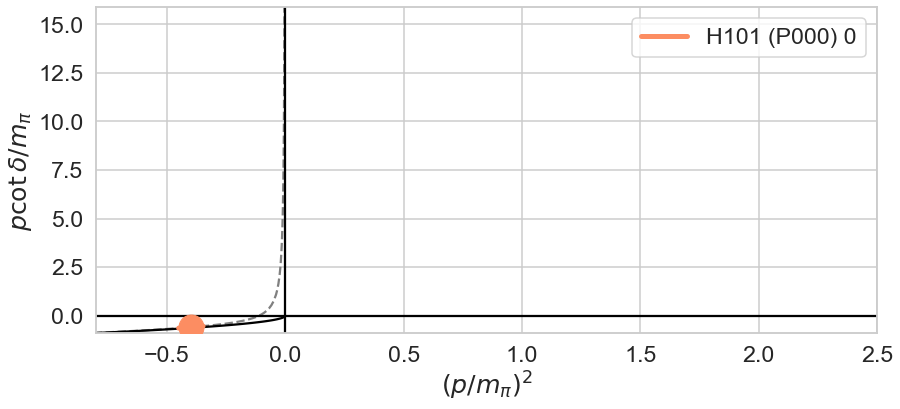

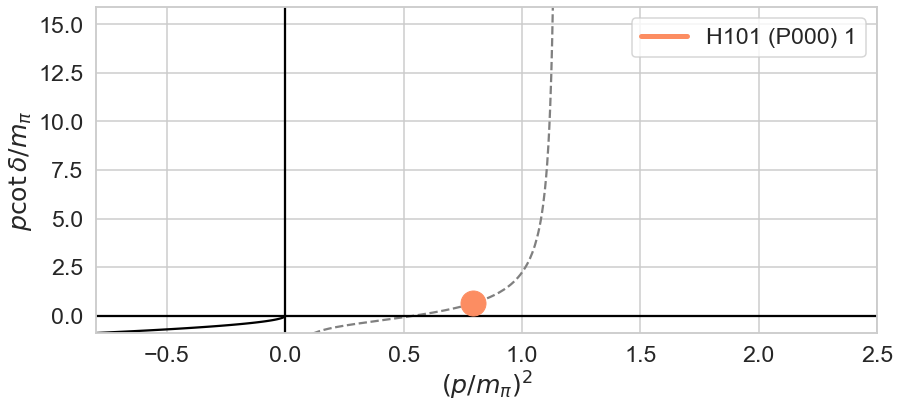

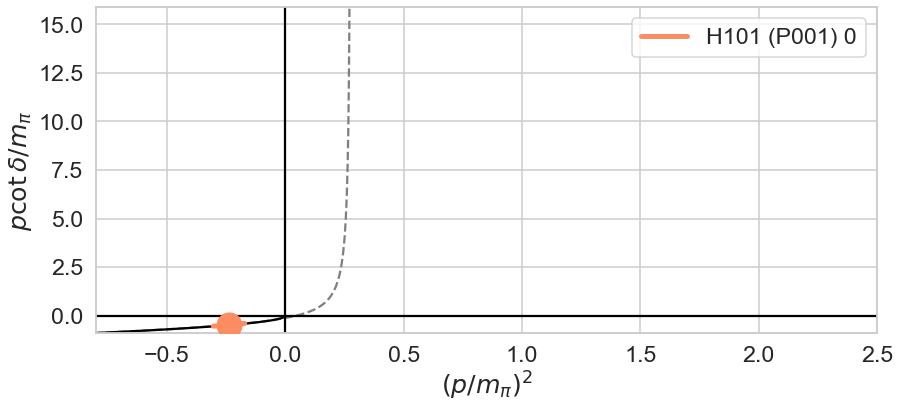

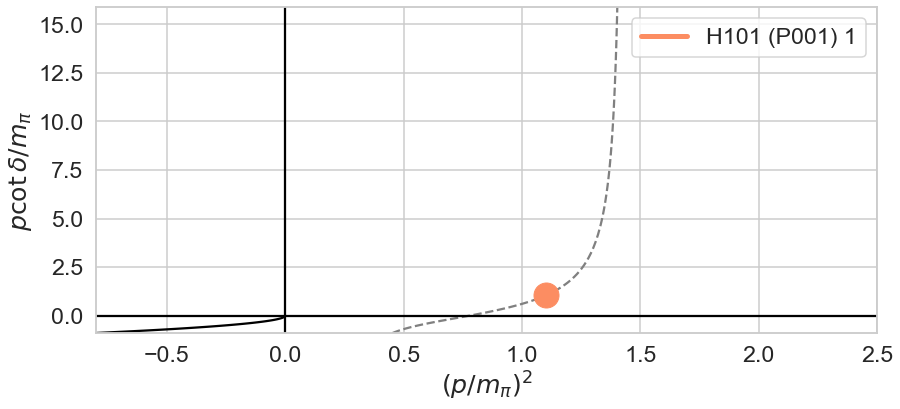

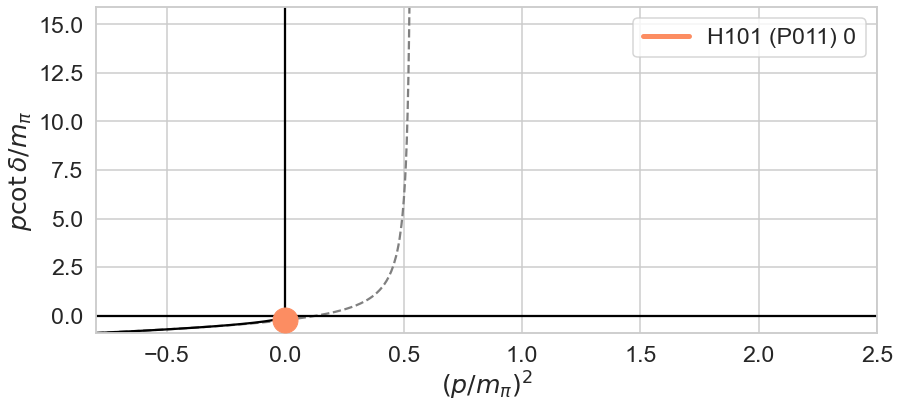

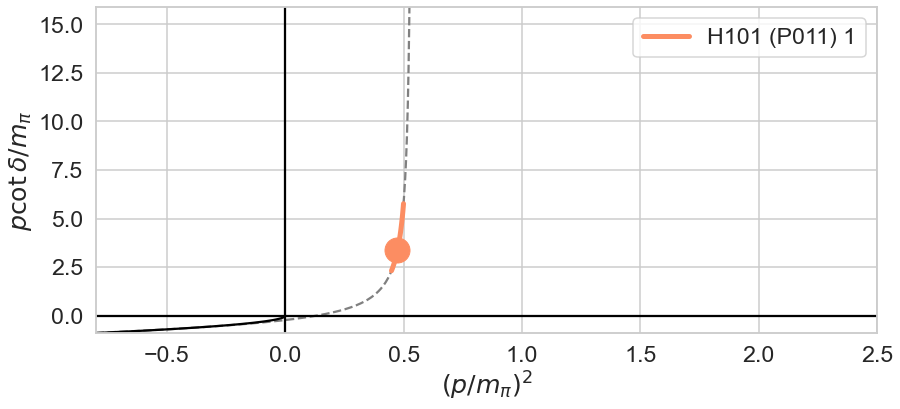

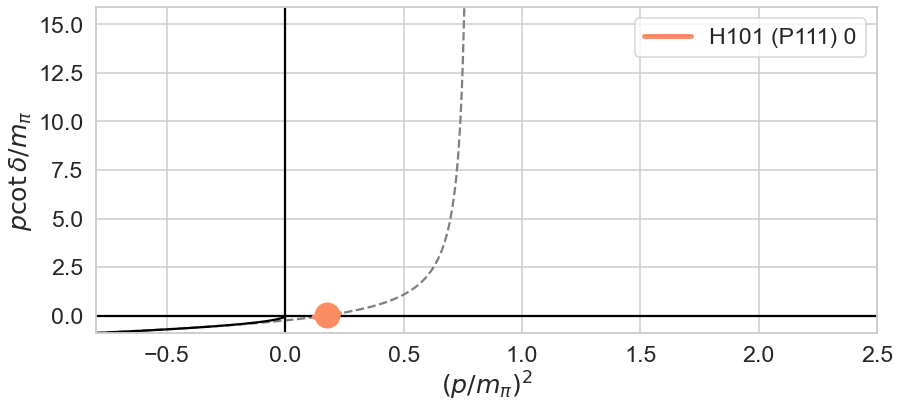

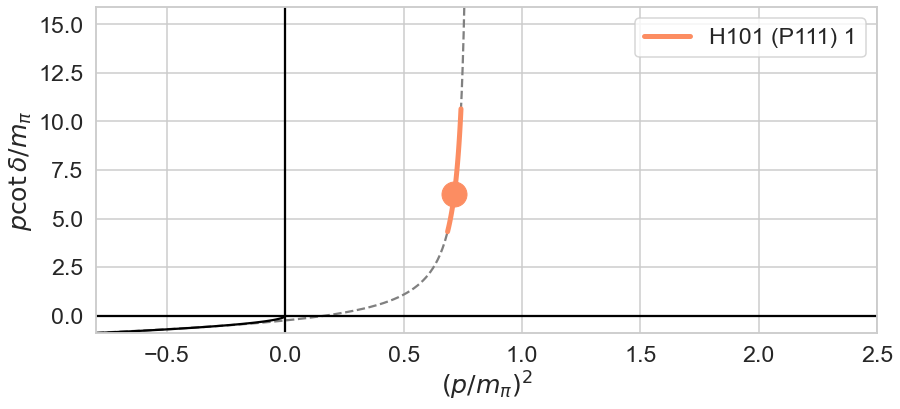

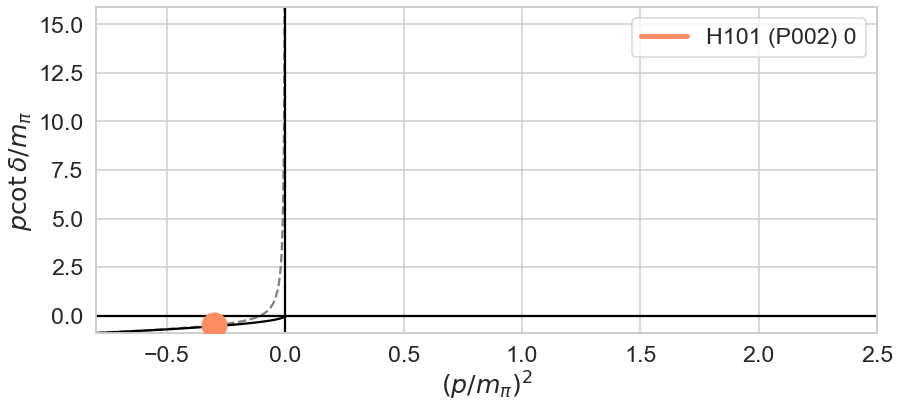

In [14]:
%%time
label = 'H101'
for frame in tqdm(['P000', 'P001', 'P011', 'P111', 'P002']):
    for level in [0, 1]:
        if (frame == 'P002') and (level == 1):
            continue
        _ = calc_kcot_vs_k2(label, frame, level, xlim=(-0.8, 2.5), ylim=(-0.9, 15.9))

100%|██████████| 5/5 [01:21<00:00, 16.21s/it]


CPU times: user 1min 12s, sys: 1.62 s, total: 1min 14s
Wall time: 1min 21s


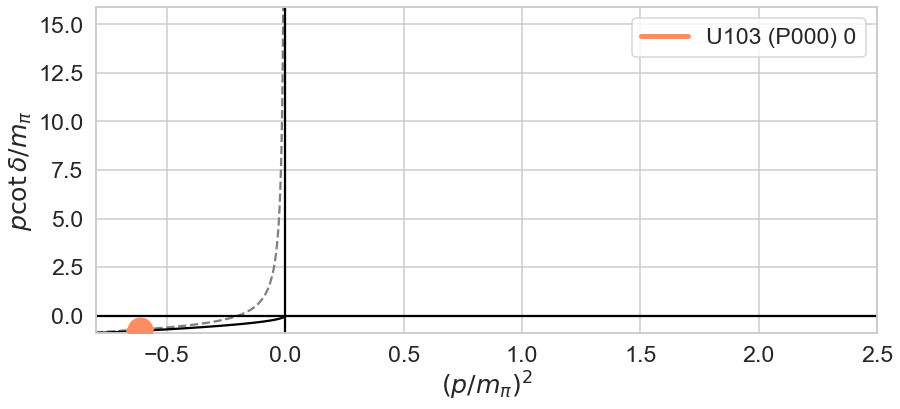

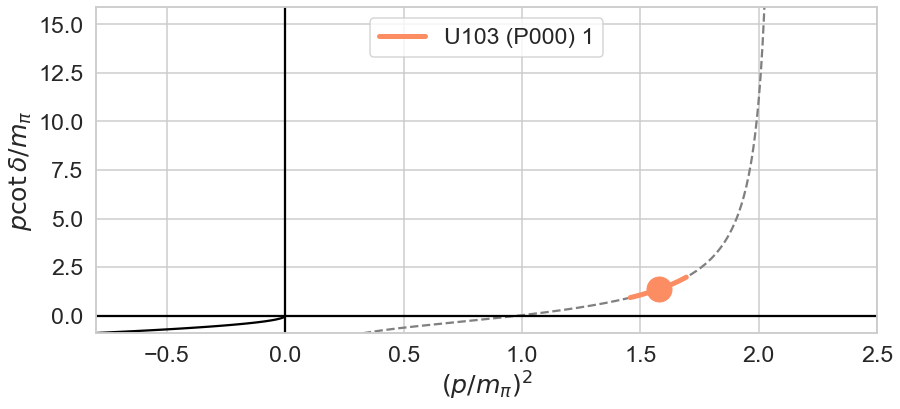

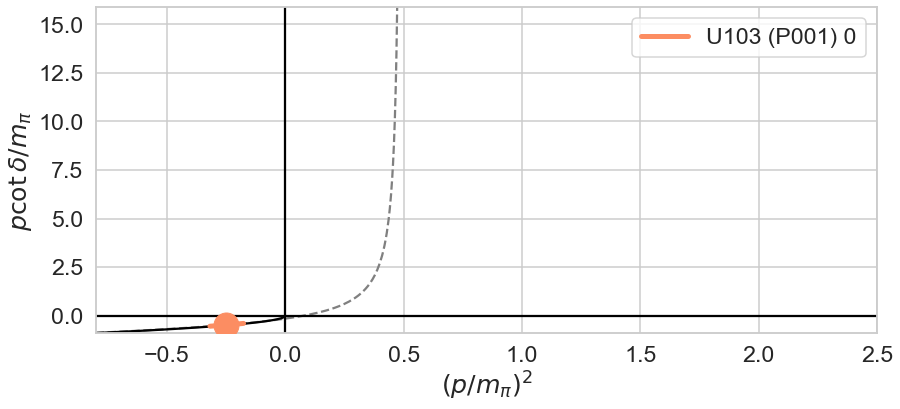

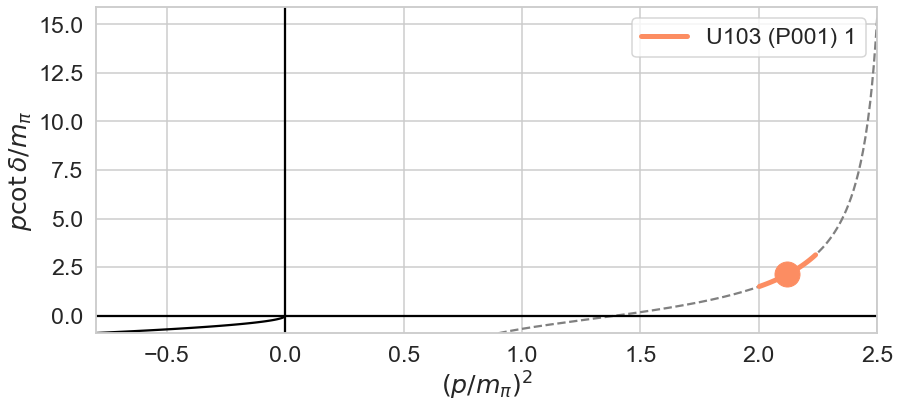

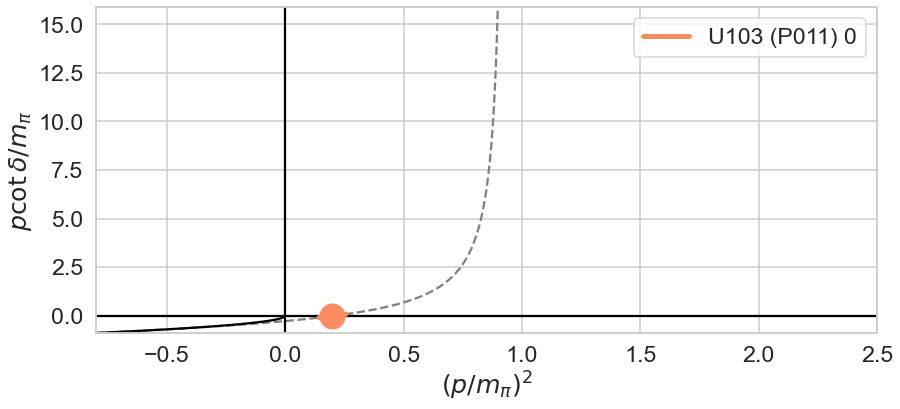

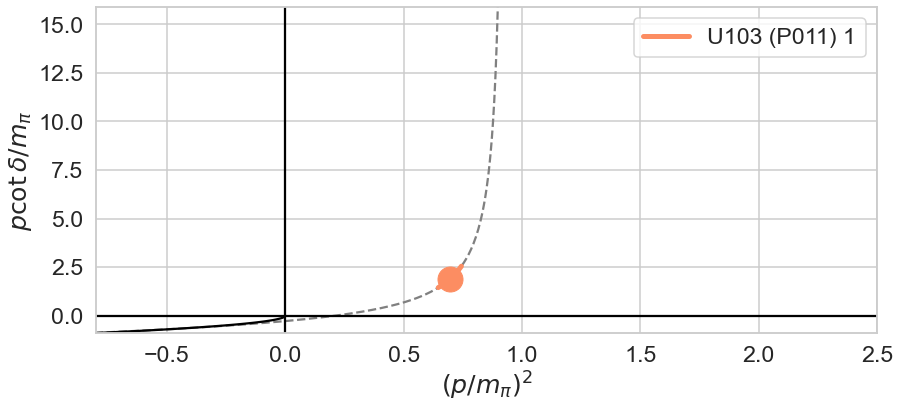

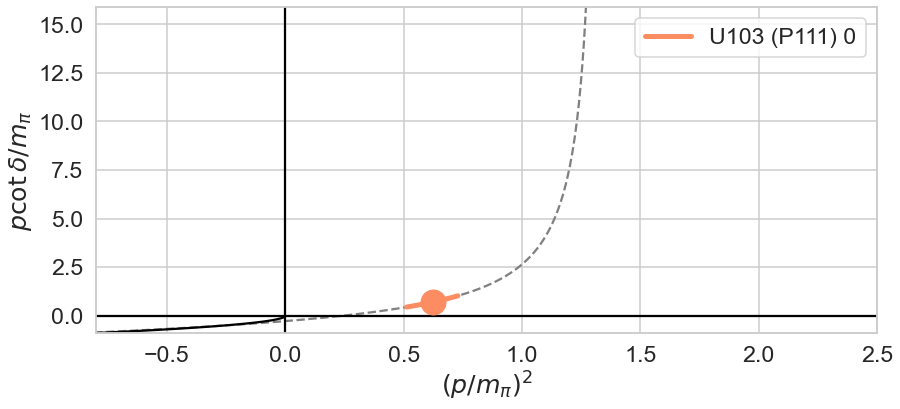

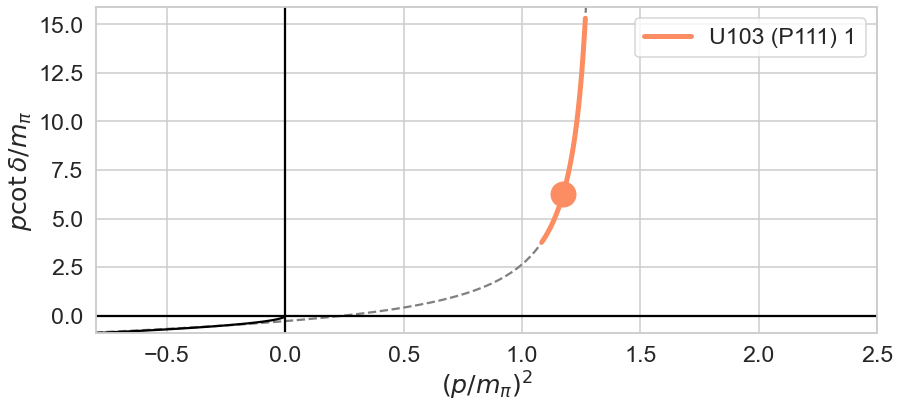

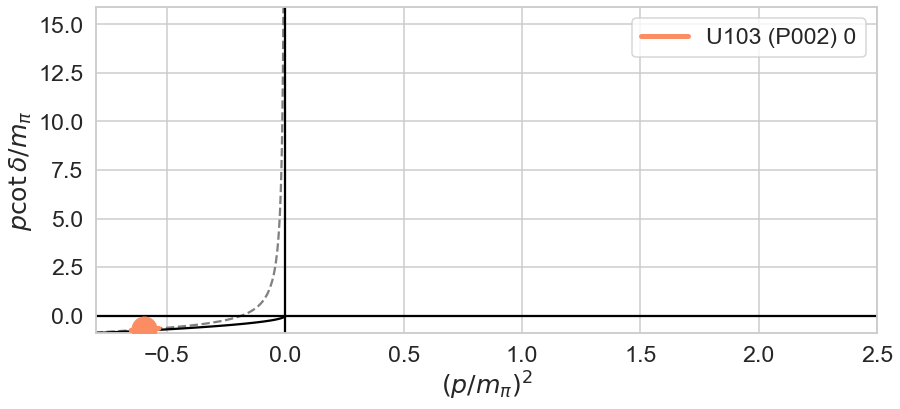

In [15]:
%%time
label = 'U103'
for frame in tqdm(['P000', 'P001', 'P011', 'P111', 'P002']):
    for level in [0, 1]:
        if (frame == 'P002') and (level == 1):
            continue
        _ = calc_kcot_vs_k2(label, frame, level, xlim=(-0.8, 2.5), ylim=(-0.9, 15.9))

100%|██████████| 5/5 [01:20<00:00, 16.04s/it]


CPU times: user 1min 8s, sys: 1.61 s, total: 1min 10s
Wall time: 1min 20s


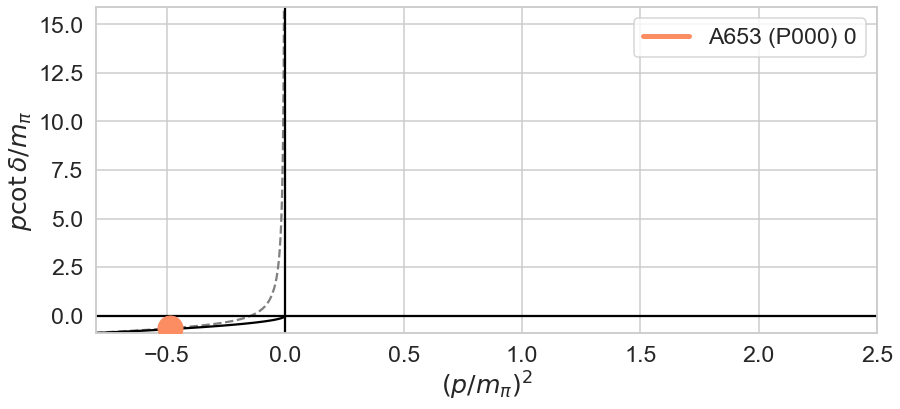

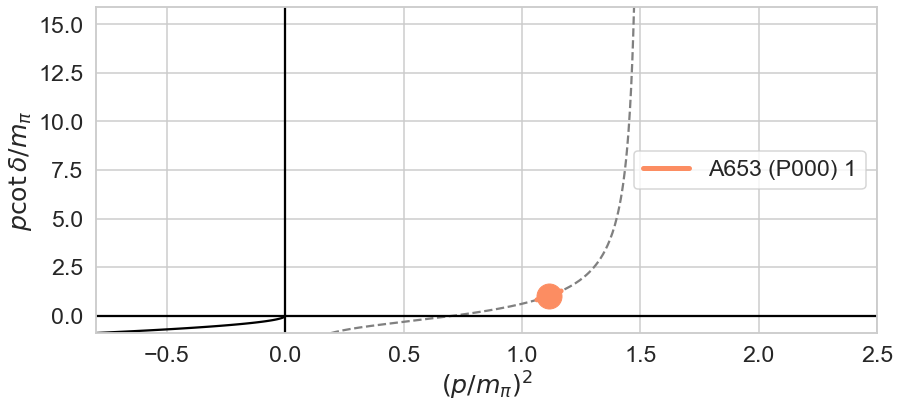

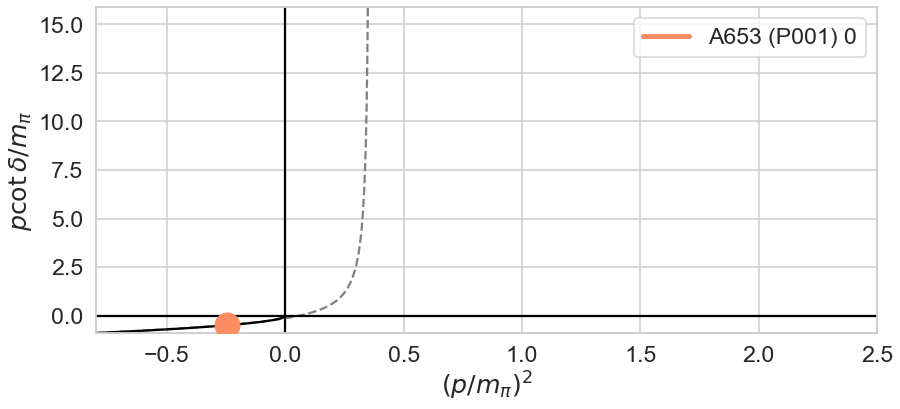

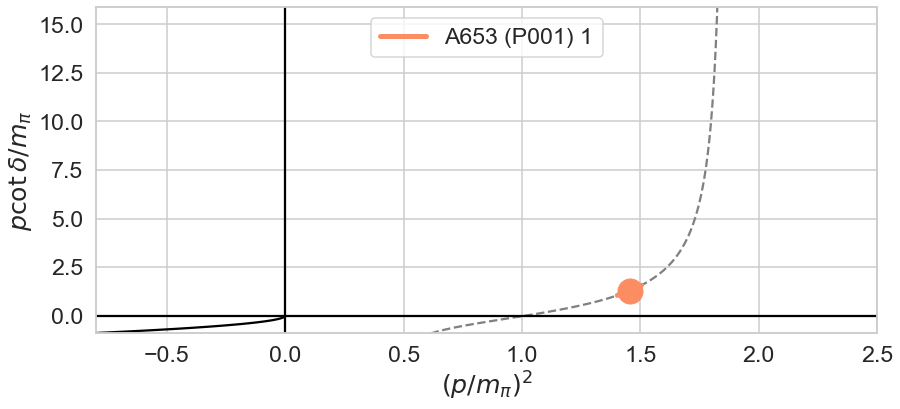

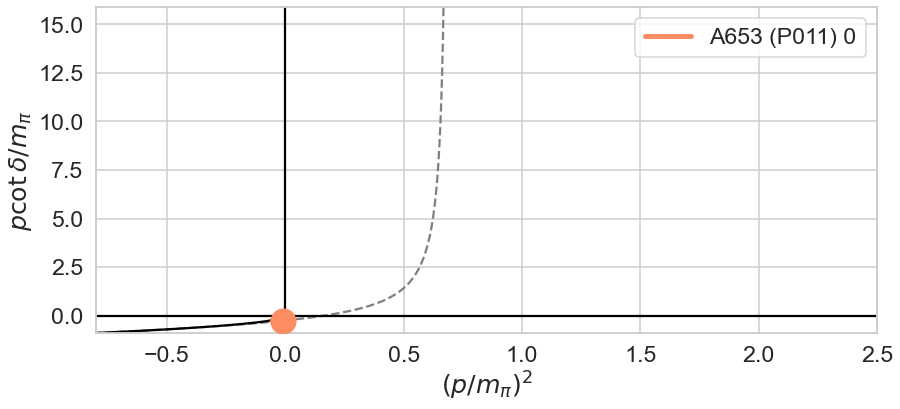

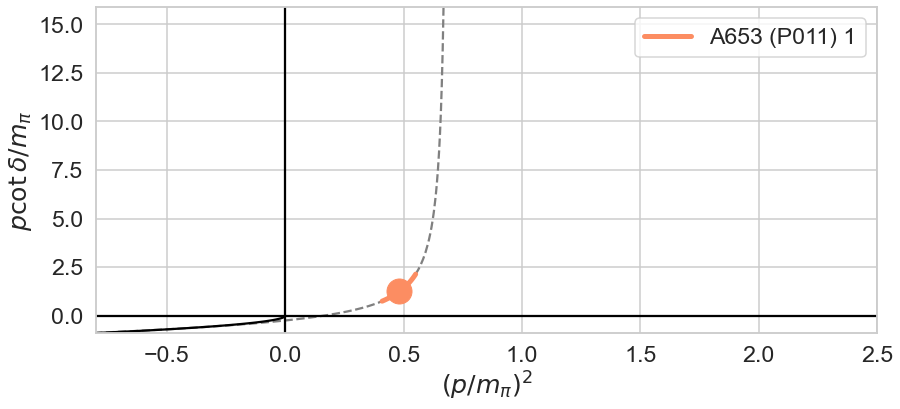

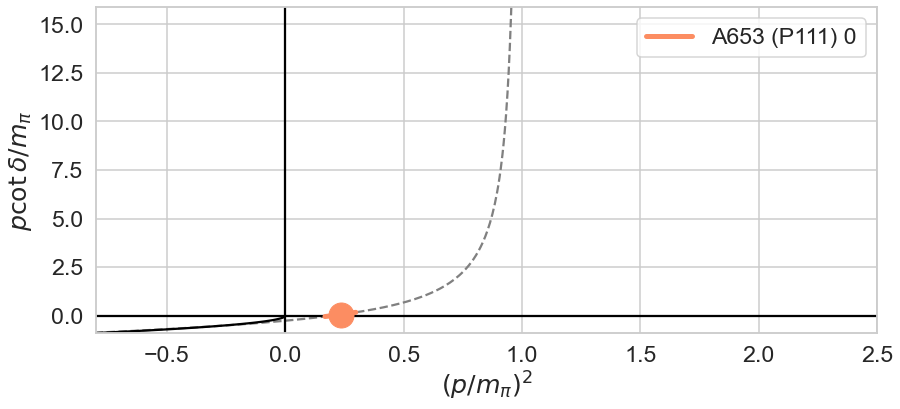

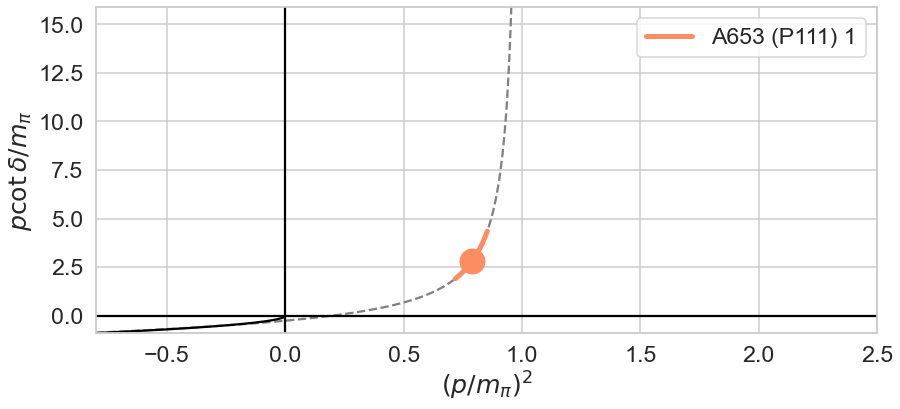

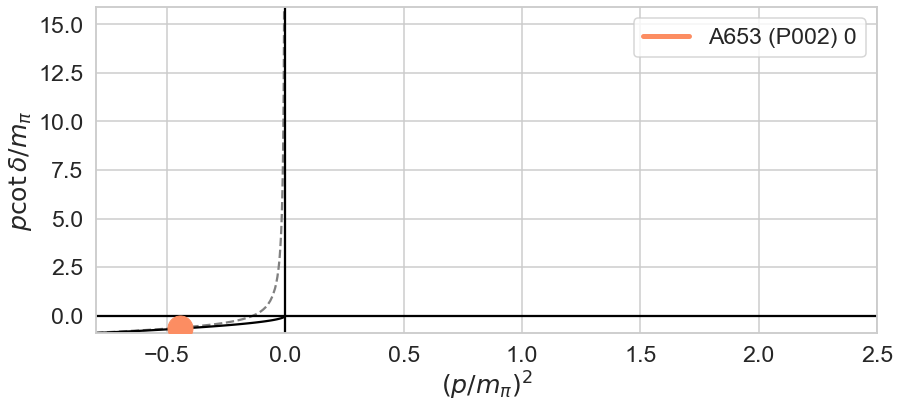

In [16]:
%%time
label = 'A653'
for frame in tqdm(['P000', 'P001', 'P011', 'P111', 'P002']):
    for level in [0, 1]:
        if (frame == 'P002') and (level == 1):
            continue
        _ = calc_kcot_vs_k2(label, frame, level, xlim=(-0.8, 2.5), ylim=(-0.9, 15.9))

100%|██████████| 5/5 [01:23<00:00, 16.69s/it]


CPU times: user 1min 13s, sys: 1.66 s, total: 1min 15s
Wall time: 1min 23s


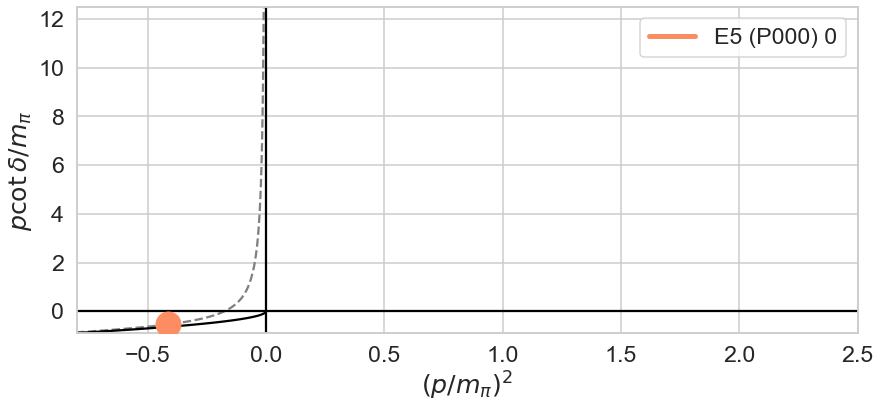

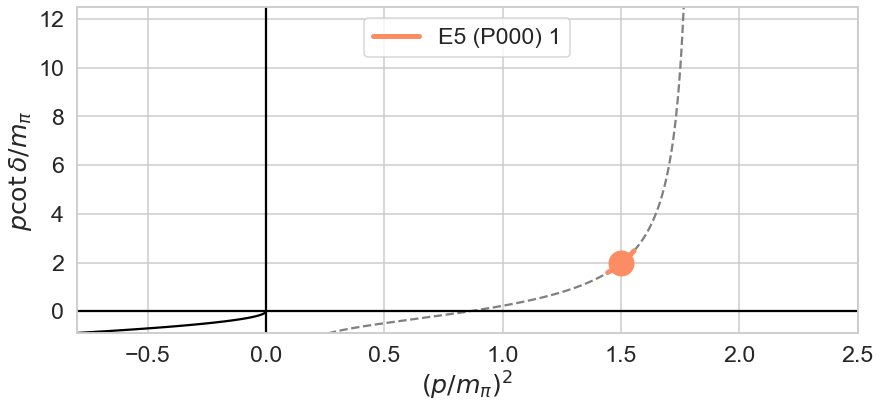

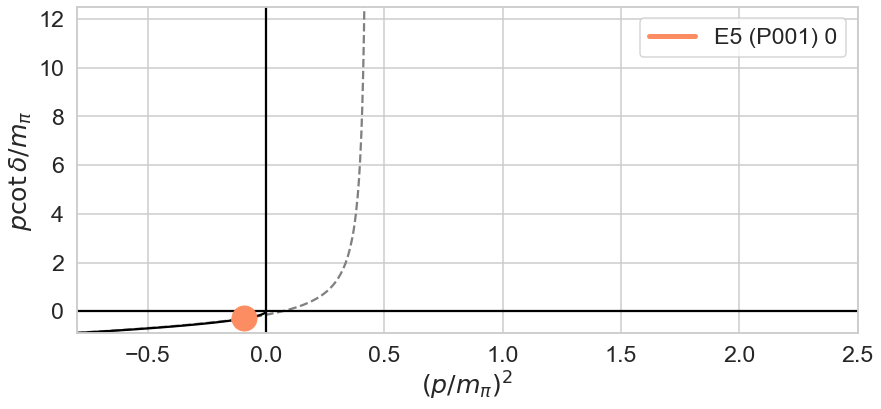

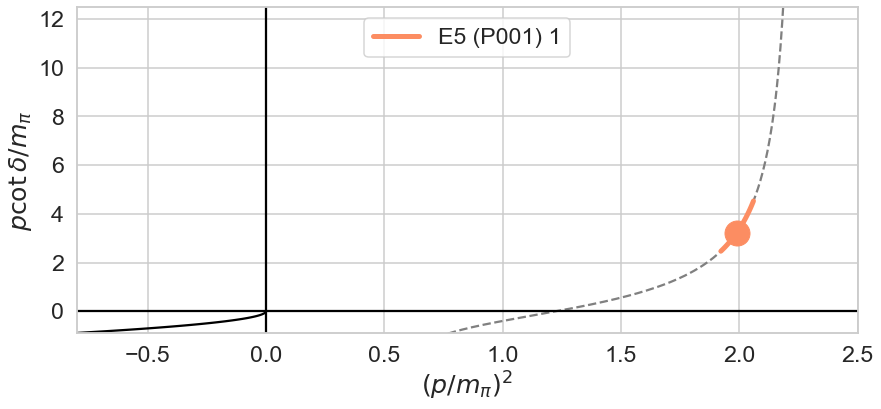

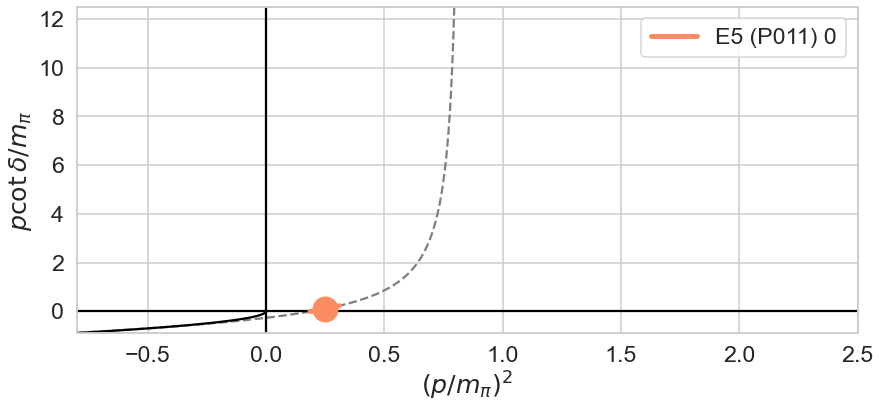

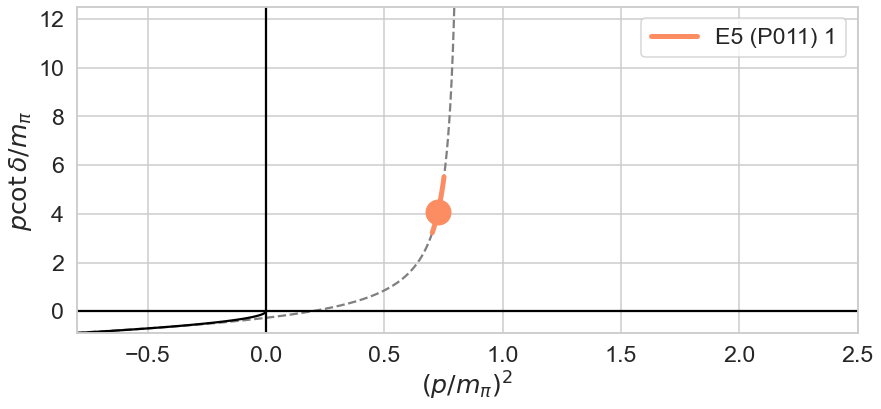

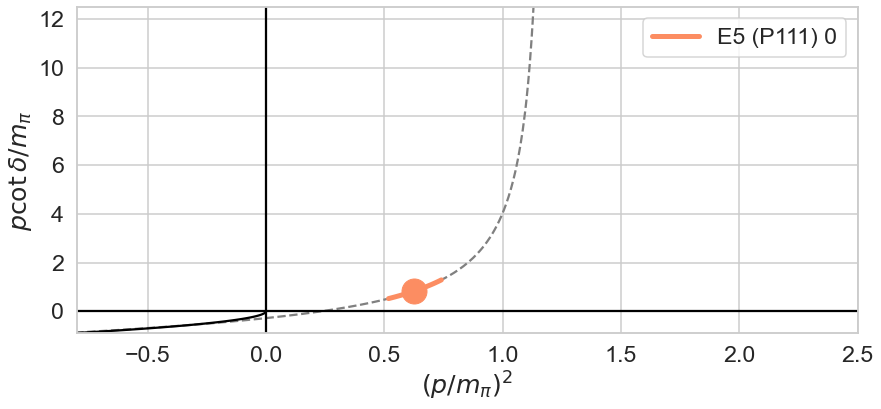

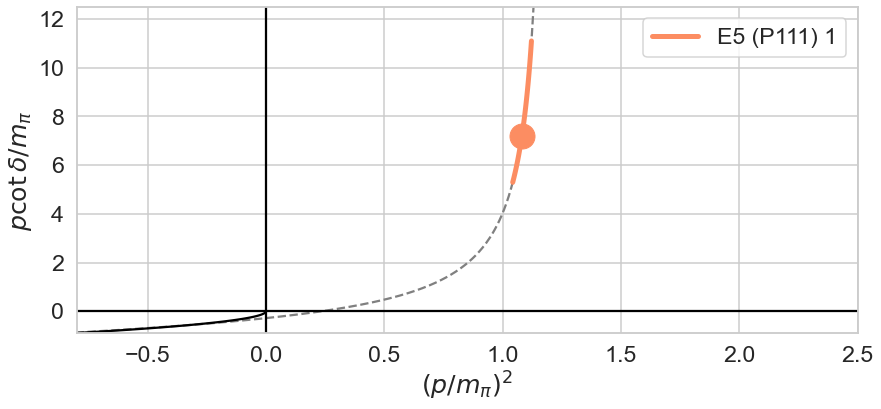

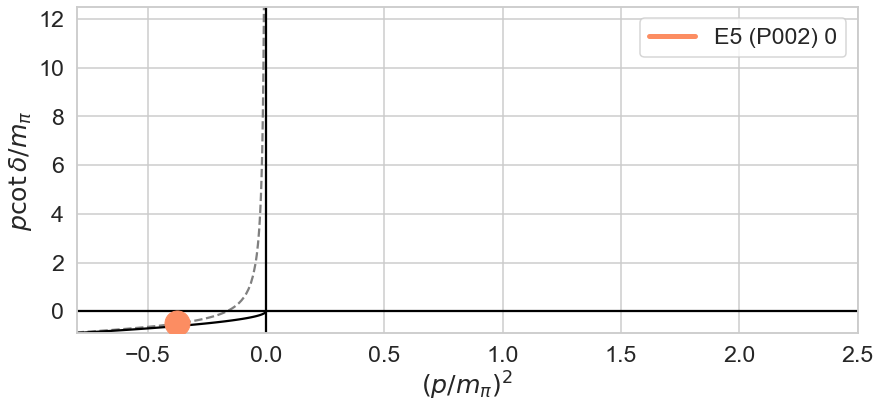

In [19]:
%%time
label = 'E5'
for frame in tqdm(['P000', 'P001', 'P011', 'P111', 'P002']):
    for level in [0, 1]:
        if (frame == 'P002') and (level == 1):
            continue
        _ = calc_kcot_vs_k2(label, frame, level, xlim=(-0.8, 2.5), ylim=(-0.9, 12.5))

100%|██████████| 5/5 [01:17<00:00, 15.48s/it]


CPU times: user 1min 1s, sys: 1.53 s, total: 1min 3s
Wall time: 1min 17s


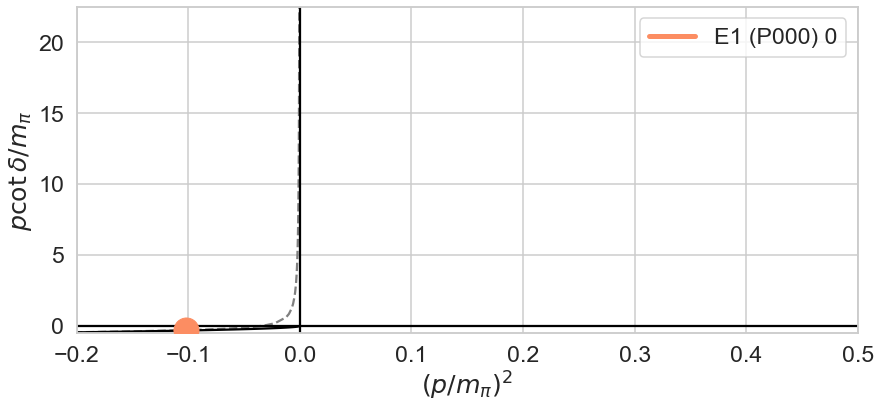

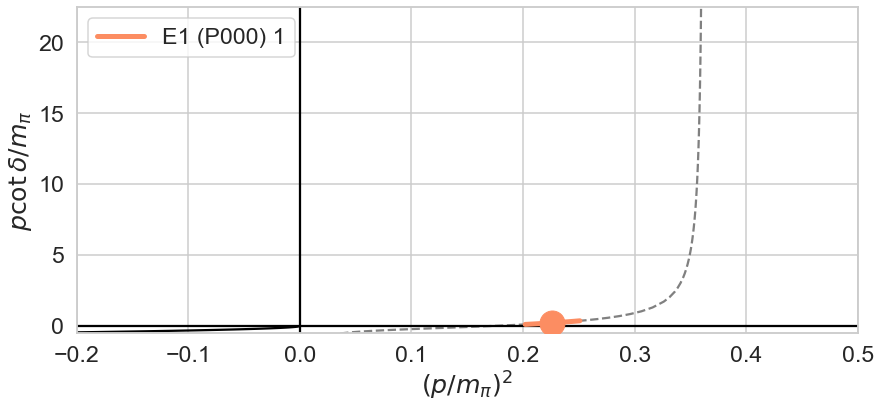

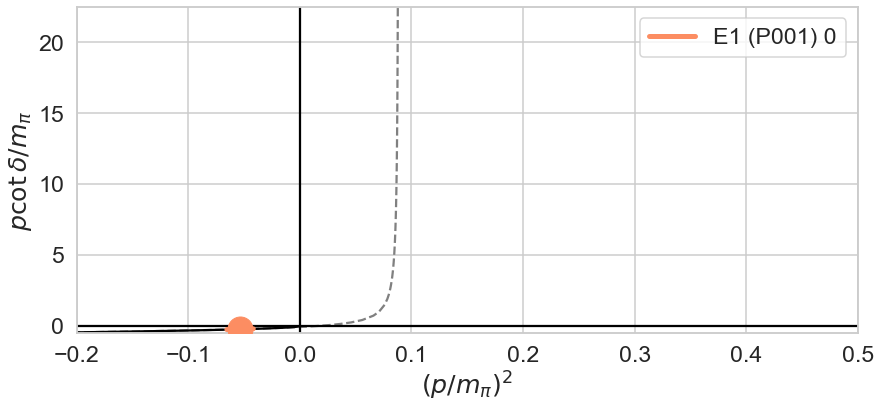

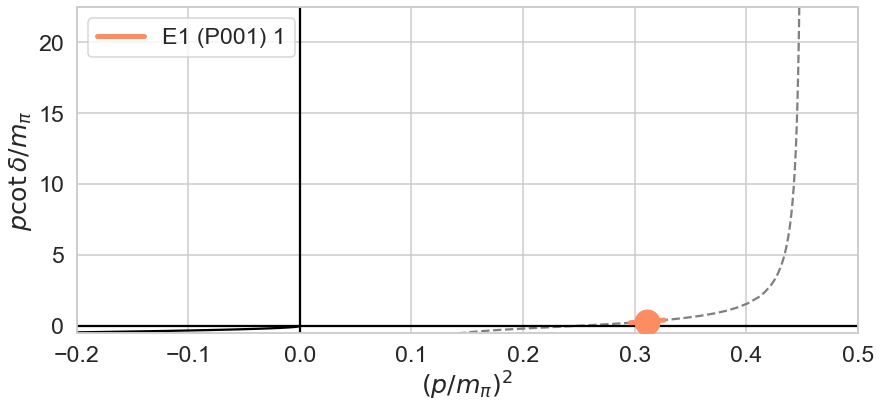

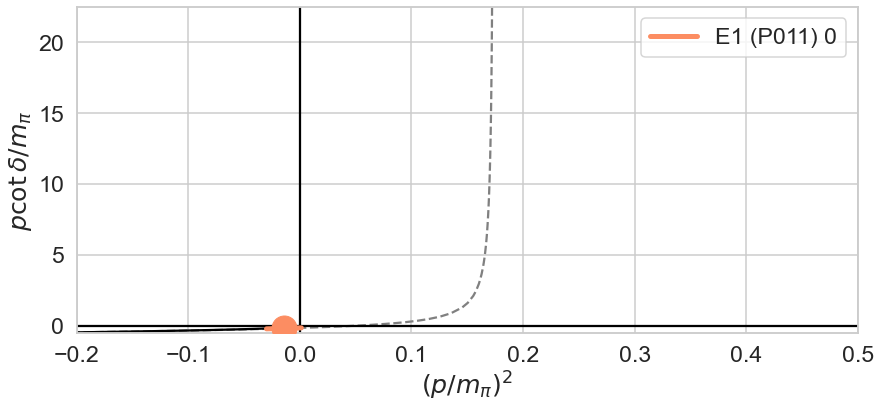

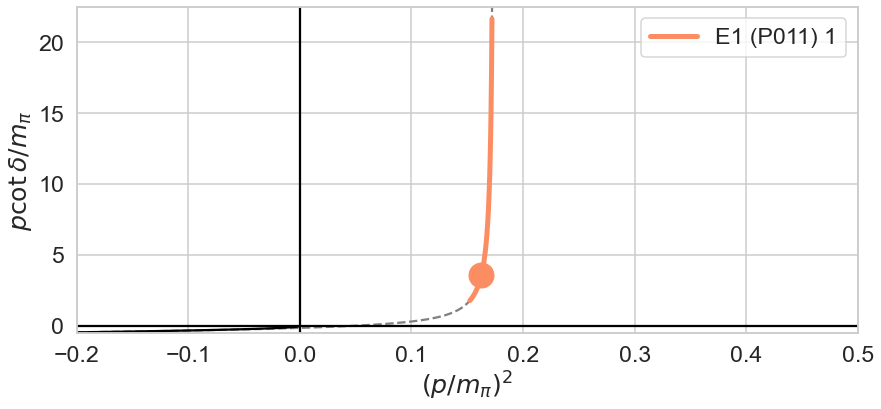

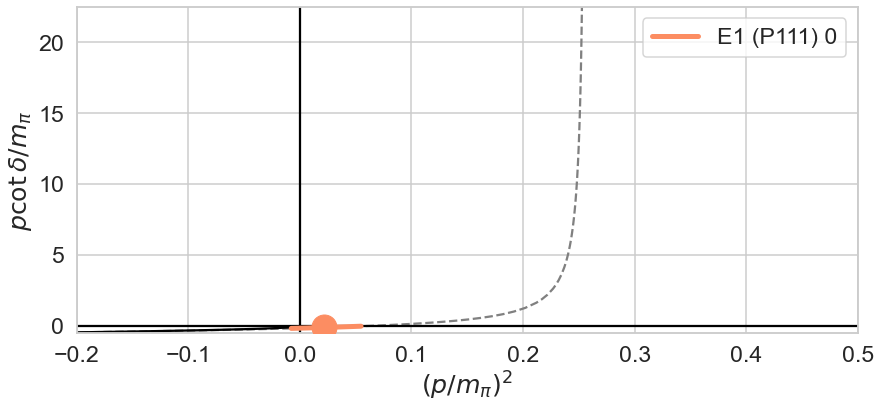

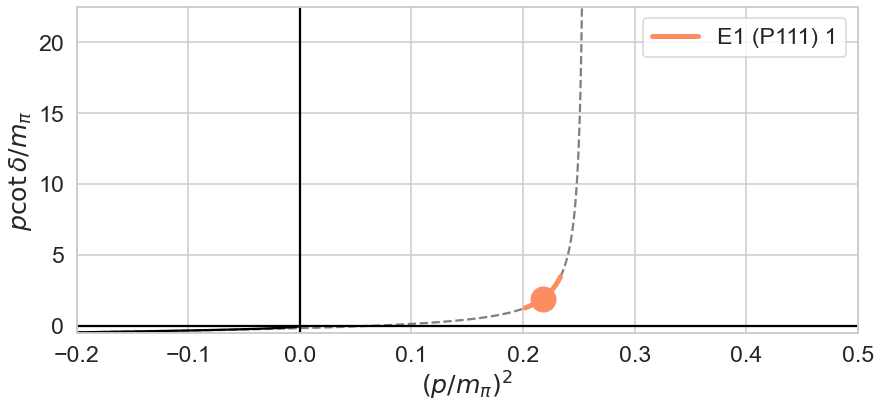

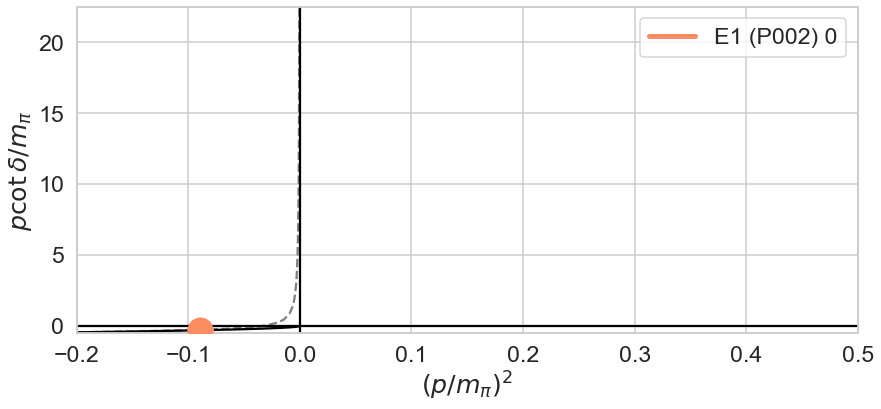

In [20]:
%%time
label = 'E1'
for frame in tqdm(['P000', 'P001', 'P011', 'P111', 'P002']):
    for level in [0, 1]:
        if (frame == 'P002') and (level == 1):
            continue
        _ = calc_kcot_vs_k2(label, frame, level, xlim=(-0.2, 0.5), ylim=(-0.5, 22.5))